In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
from scipy.misc import comb
import scipy.stats as ss
from scipy.stats import beta, chisqprob
from scipy.special import gamma as gammaf # This is dumb but better for the moment than fixing code against jon's
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from __future__ import division

import json
from sys import maxint
from scipy.special import binom
from IPython.display import display, HTML
from sklearn.cross_validation import KFold
import community as cu


In [2]:
# Inline all plots to cell outputs
%matplotlib inline

Bradscratch stuff below here

In [3]:
# Data reading and distance calculation utilities
def read_metadata(meta_file):
    with open(meta_file, 'r') as f:
        my_json = json.loads(f.read())
    return {json.loads(key): value for (key, value) in my_json.iteritems()}

def read_table(table_file):
    with open(table_file, 'r') as f:
        # This will initially read the keys in the k:v pairs as just strings
        my_json = json.loads(f.read())
    # Convert keys string->list; but cannot hash on a list, so conver to a tuple for use in the map
    return {tuple(json.loads(key)): value for (key, value) in my_json.iteritems()}

def get_groups_and_libraries(meta):
    groups = []
    libraries = []
    for key in meta.keys():
        libraries.append(meta[key]['mAttributes']['LB'])
        groups.append(meta[key]['mReadGroupId'])
    return (groups, libraries)

def package_and_sort(matrix, groups, libraries):
    arrays = [np.array(groups), np.array(libraries)]
#     df = pd.DataFrame(matrix, index=arrays, columns=arrays).sort_index(level=1).sort_index(level=1, axis=1)
    df = pd.DataFrame(matrix, index=arrays, columns=arrays).sortlevel(level=1).sortlevel(level=1, axis=1)
    df.index.names=["group", "library"]
    return df


In [4]:
# Getting the truth matrix after precomputing the distances.
# Because this can be cached too, but is faster to get
# Also more frequesnt to change
# Therefore helps to be lower down in the stack
def make_truth_matrix(groups, libraries):
    n_groups = len(groups)
    truth = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            if i == j:
                truth[i,j] = -1  # sentinal value so the diagonal doesn't bias with evaluation metrics
            elif libraries[i] == libraries[j]:
                truth[i,j] = 1
    return package_and_sort(truth, groups, libraries)

# truth = make_truth_matrix(groups, libraries)

In [5]:
# Distance functions and utility functions by Jon Bloom

def load_table(sample):
    f = open(sample + '.table.txt', 'r')
    read_groups = eval(f.readline())
    libraries = eval(f.readline())
    n_reads = eval(f.readline())
    n_reads_removed = eval(f.readline())
    table = eval(f.readline())
    f.close()
    return read_groups, libraries, n_reads, n_reads_removed, table

def group_sizes(table, n_groups):
    '''Returns vector v where v[i] is count of reads in group i.'''
    rg_sizes = np.zeros(n_groups, dtype=int)
    for item in table.items():
        for i in item[0]:
            rg_sizes[i] += item[1]
    return rg_sizes

def remove_empty_groups(read_groups, libraries, table):
    n_groups = len(read_groups)
    rg_sizes = group_sizes(table, n_groups)
    if np.prod(rg_sizes != 0):
        return read_groups, libraries, table
    else:
        groups = [read_groups[i] for i in range(n_groups) if rg_sizes[i] != 0]
        libs = [libraries[i] for i in range(n_groups) if rg_sizes[i] != 0]
        new_num_of_old_num = {}
        current_num = 0
        for i in range(n_groups):
            new_num_of_old_num[i] = current_num
            if rg_sizes[i] != 0:
                current_num += 1
        new_table = Counter()
        for item in table.items():
            new_key = tuple(map(lambda x : new_num_of_old_num[x], list(item[0])))
            new_table.update({new_key : item[1]})
        return groups, libs, new_table
    
def library_nums(libraries):
    n_groups = len(libraries)
    num_of_library = {}
    current_num = 0
    for i in xrange(n_groups):
        if libraries[i] not in num_of_library.keys(): #change to set_default
            num_of_library[libraries[i]] = current_num
            current_num += 1
    return np.array([num_of_library[libraries[i]] for i in xrange(n_groups)])

def library_colors(lib_nums):
    #lib_color = plt.cm.Set1(lib_nums / (n_libraries + 1))
    color_of_num = {0 : 'r', 1 : 'b', 2 : 'g', 3 : 'k', 4 : 'y', 5 : 'm', 6 : 'c'}
    return [color_of_num[lib_num % 5] for lib_num in lib_nums]

def library_matrix(lib_nums, n_groups):
    lib_matrix = np.zeros((n_groups,n_groups), dtype=bool)
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            lib_matrix[i,j] = (lib_nums[i] == lib_nums[j])
    return lib_matrix

# jaccard similarity. union/intersection. might not be robust to diff conditions. no a priori expectation
def overlaps(table, n_groups):
    '''Returns matrix where M[i][j] is count of read types in both groups i
       and group j (symmetrized)'''
    overlap_matrix = np.zeros((n_groups, n_groups))
    for item in table.items():
        groups = list(set(item[0]))
        l = len(groups)
        for i in xrange(0,l):
            for j in xrange(i,l):
                overlap_matrix[groups[i],groups[j]] += item[1]
    return (overlap_matrix + overlap_matrix.T) / 2

def inner_product(table, n_groups):
    '''Returns matrix X^t * X where X[i,j] is count of reads of type i in group j.
       Agrees with all_pairs off the diagonal.'''
    ip_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        count_vector = np.zeros(n_groups)
        for i in xrange(l):
            count_vector[item[0][i]] += 1
        ip_matrix += np.outer(count_vector, count_vector) * item[1]
    return ip_matrix


# ABB would be 3 pairs- AB, AB, BB
# Retain signal from non-exact pairs. didn't do this as the only metric bc seeing a lot of on-flowcell pad-hopping duplicates, showing up as large duplicate sets, which would dominate here
# We only want biological duplicates, and we have been better at marking these. The work yossi and david benj are doing. What's going on from david roazen.
# That wasn't ready yet, so he did an exact pairs approach as well.
# This one is probably best if you are careful to look at only biological duplicates
def all_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j (symmetrized).'''
    ap_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        for i in xrange(l-1):
            for j in xrange(i+1,l):
                ap_matrix[item[0][i],item[0][j]] += item[1]
    return (ap_matrix + np.tril(ap_matrix.T))/2

def exact_tuples(table, n_groups, k):
    '''Returns array where A[i_1,...i_k] is count of read types that occur
       exactly in the groups i_1,...,i_k ascending with repeats.'''
    et_array = np.zeros(k*(n_groups,))
    for item in table.items():
        if len(item[0])==k:
            et_array[item[0]] = item[1]
    return et_array

def exact_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of read types that occur exactly twice,
       once in group i and once in group j (symmetrized).'''
    ep_matrix = exact_tuples(table, n_groups, 2)
    return (ep_matrix + np.tril(ep_matrix.T))/2

def normalize(array):
    return array/np.sum(array)

# normalize such that diagonals are 1 (so 1 is max self-similarity). off-diag things scaled proportionally
def normalize_by_diagonal(matrix):
    diag = np.diagonal(matrix)
    return matrix / np.sqrt(np.outer(diag, diag))

# take the outer product of [pq] with itself
# ie [[p^2, pq], [pq, q^2]]
# so divide matrix by [[p, rad(pq)], [rad(pq), q]]
# so each cell is divided by the total number of elements in it's thing.
# most similar to the underlying model
def normalize_by_group_size(matrix, group_sizes):
    return matrix / np.sqrt(np.outer(group_sizes, group_sizes))

def normalize_rows_by_vector(matrix, vector):
    return matrix / vector[:, np.newaxis]

def overlap_affinity(table, n_groups):
    ol_matrix = overlaps(table, n_groups)
    ol_affinity = np.zeros((n_groups, n_groups))
    for i in xrange(n_groups):
        ol_affinity[i,i] = .5
        for j in xrange(i+1,n_groups):
            ol_affinity[i,j] = 2 * ol_matrix[i,j] / \
                               (ol_matrix[i,i] + ol_matrix[j,j] - 2 * ol_matrix[i,j])
    return ol_affinity + ol_affinity.T

def exact_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(exact_pairs(table, n_groups))

def all_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(all_pairs(table, n_groups))

# Distance in euclidean space between 2 vectrs. each RG is a vector in a space whose dimension is the number of non-zero entries in the union of observed inserts
# so, what's teh cosine fo the angle between these 2 vectors
# naturally, the diagonal elements will be 1
# cosine of angle = (A dot B) / (length A)(length B)

# BUT our data isn't in the form of these vectors. So we count the AB pairs.
# Recording each time he sees some combination of 2 numbers.

# suffers the same issue as jaccard- what is your expectation. this is why all pairs and exact pairs only viable.
def L2_affinity(table, n_groups):
    return normalize_by_diagonal(inner_product(table, n_groups))

def exact_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def exact_pairs_affinity3(table, n_groups, rg_sizes):
    return (normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def all_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(all_pairs(table, n_groups),rg_sizes))

def zero_diag(matrix):
    new_matrix = matrix.copy()
    for i in xrange(matrix.shape[0]):
        new_matrix[i,i] = 0
    return new_matrix

def multiplicity_matrix(table, n_groups):
    '''Returns M with M_ij count of j-tuples in group i'''
    max_mult =  max(map(len,table.keys()))
    mult_matrix = np.zeros((n_groups, max_mult + 1), dtype=int)
    for i in xrange(n_groups):
        mult_vector = multiplicity_vector(subtable(table,i))
        for j in xrange(len(mult_vector)):
            mult_matrix[i,j] = mult_vector[j]
    return mult_matrix

def multiplicity_vector(table):
    '''Returns v with v_j count of j-tuples in table'''
    max_mult =  max(map(len,table.keys()))
    mult_vector = np.zeros(max_mult + 1, dtype=int)
    for item in table.items():
        mult_vector[len(item[0])] += item[1]   
    return mult_vector

def subtable(table, i):
    '''Returns subtable for group i'''
    group_table = Counter()
    for item in table.items():
        mult = item[0].count(i)
        if mult > 0:
            group_table.update({(i,)*mult : item[1]})
    return group_table

def plot_matrix_rows(matrix, title = 'Matrix rows'):
    max_mult = np.sum(np.sum(matrix,axis=0) > 0) - 1
#     size = len(matrix[0])
    for i in xrange(n_groups):
        plt.semilogy(range(1, max_mult + 3), matrix[i,1:max_mult + 3],
                 label=i, color = plt.cm.Set1(i/n_groups))
    #plt.yscale('log')
    plt.ylim(np.min(matrix), 10 * np.max(matrix))
    plt.title(title)
#     plt.legend(title='RG')
    plt.show() #change ticks to integers only

def plot_matrix(matrix, title='Matrix', vmax=None, ax=None):
    if ax is None:
        ax = plt.gca()
    n, m = matrix.shape
    
    colors = ax.pcolor(matrix, edgecolor='k', cmap = plt.cm.Blues, vmin=0, vmax=vmax)
    plt.colorbar(colors, ax=ax)
    ax.set_xticks(np.arange(n)+0.5)
    ax.set_yticks(np.arange(m)+0.5)
    ax.set_xticklabels(np.arange(n))
    ax.set_yticklabels(np.arange(m))
    ax.set_title(title)
    ax.invert_yaxis()

def normalize_to_Markov(matrix):
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:, np.newaxis]
    
def eigen(affinity):
    #change to computer for symmetrix matrix and convert?
    #is absolute value necessary? correct? won't fractoinal powers cause trouble?
    evals, evecs = np.linalg.eig(normalize_to_Markov(affinity))
    order = np.argsort(np.abs(evals))[::-1]
    return evals[order], evecs[:,order]

def diffusion_distances(evals, evecs, t = None):
    if not t:
        t = 1 / (1-evals[1])
    n_groups = len(evals)
    scaled_evecs = evecs[:,1:] * evals[1:]**t  #check that this works as expected
    dd_matrix = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        dd_matrix[i,i]=0
        for j in xrange(i+1, n_groups):
            difference = scaled_evecs[i,:] - scaled_evecs[j,:]
            dd_matrix[i,j] = np.sqrt(np.dot(difference,difference))
    return dd_matrix + dd_matrix.T

def plot_diffusion(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lib_nums = library_nums(libraries)
    ax.scatter(x, y, color=color)
    ax.set_title(title)
    if bound:
        ax.set_xlim(-bound,bound)
        ax.set_ylim(-bound,bound)
    plt.show()

def plot_diffusion_3d(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    z = evecs[:,3]*(evals[3]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter3D(x, y, z, color = color)
    ax.set_title(title)
    if bound:
        ax.set_xlim3d(-bound,bound)
        ax.set_ylim3d(-bound,bound)
        ax.set_zlim3d(-bound,bound)
    plt.show()

def scatter_affinities(affinities, lib_matrices, pair_colors, log_scale = False, title='Scatter'):   
    fig = plt.figure(figsize=(10,8))
    xs = np.arange(len(pair_colors))
    plt.scatter(xs, affinities, s=2, color = pair_colors)
    plt.title(title)
    plt.ylim(1e-6,1)
    if log_scale == True:
        plt.yscale('log')
    for i in xs:
        if lib_matrices[i] == 3:
            plt.axvline(x=i,ls='-',alpha = .5,c='g',linewidth=1,)
    plt.show()
    
def plot_graph(matrix, threshold, color=None, complement = False):
    print 'Threshold =', threshold #include this in title
    n_groups = matrix.shape[0]
    labels = dict(zip(range(n_groups),range(n_groups)))
    if complement:
        G = nx.Graph(matrix < threshold)
    else:
        G = nx.Graph(matrix >= threshold)
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color=color)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos,labels=labels,font_color='w',font_size=16)
    plt.show()
    
def bool_to_color(x):
    if x == True:
        return 'b'
    elif x == False:
        return 'r'
    else:
        return 'w'

# Some snippets from other J Bloom functions, which I found interesting
# pair_colors = np.vectorize(bool_to_color)(lib_matrices)
# np.set_printoptions(precision=1, suppress=True)

In [6]:
# threshold getter functions

# TODO - what if min <= max????
def min_max_mean(distances, truth):
    all_positives = distances.values[truth > 0]
    all_negatives = distances.values[truth == 0]
    return np.mean([min(all_positives), max(all_negatives)])

def exhaustive_search(distances, truth):
    n_groups = len(distances.index.values)
    sorted_dists = np.sort(np.unique(distances.values))
    max_rand_index = 0
    max_rand = 0.0
    for index in xrange(len(sorted_dists)):
        results = apply_threshold(distances, sorted_dists[index])
        rand = summarize_result(results, truth, n_groups).loc["Rand index"].values[0]
        if rand > max_rand: max_rand_index = index
    return sorted_dists[max_rand_index]
    
# Generic outer function - Dont think I need
# def get_threshold(distances, truth, threshold_func):
#     return threshold_func(distances, truth)

In [7]:

def limited_pairs(table, n_groups, k):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j, up to a certain read type size k (symmetrized).'''
    lp_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        if len(item) <= k:
            l = len(item[0])
            for i in xrange(l-1):
                for j in xrange(i+1,l):
                    lp_matrix[item[0][i],item[0][j]] += item[1]
    return (lp_matrix + np.tril(lp_matrix.T))/2


def random_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of each read type assigned to the 
       random group i,j drawn from the larger read type (symmetrized).'''
    rp_matrix = np.zeros((n_groups, n_groups))
    faf = np.zeros((n_groups, n_groups))
    for item in table.items():#[:6]:
        tup = item[0]
        if len(tup) > 1:
            pair = np.random.choice(tup, size=2, replace=False)
            rp_matrix[min(pair), max(pair)] += item[1]
    return (rp_matrix + np.tril(rp_matrix.T))/2

def random_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(random_pairs(table, n_groups))

def unlimited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, maxint))

def ten_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 10))

def five_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 5))

def four_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 4))

def three_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 3))

def two_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 2))

In [8]:
# Funcions supporting a likelihoods ratio test.
def fit_beta_distributions(distance, truth):
    # In practice my true-diff-library values are often all 0.0. Faux counts save my true-different beta dist from being entilely 0.
#     faux_counts = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
    distance = distance.clip(10**-12, 1.0 - (10**-12)) # was (None, 0.999999999)
    faux_counts = []
    
    # Fit a beta distribution to the true positives
#     true_positives=np.append(distance.values[truth.values>0], faux_counts)
    true_positives=distance.values[truth.values>0]
    alphaT, betaT, locT, scaleT = beta.fit(true_positives, floc=0, fscale=1)
    dPos = beta(alphaT, betaT, locT, scaleT) # "freeze" the distribution parameters as an object
    pos_dist = {"alpha": alphaT, "beta": betaT, "dist": dPos}
    
    # Fit a beta distribution to the true negatives
#     true_negatives=np.append(distance.values[truth.values==0] + 10**-27, faux_counts)
    true_negatives=(distance.values[truth.values==0] + 10**-27)
    alphaN, betaN, locN, scaleN = beta.fit(true_negatives, floc=0, fscale=1)
    dNeg = beta(alphaN, betaN, locN, scaleN)
    neg_dist = {"alpha": alphaN, "beta": betaN, "dist": dNeg}
    
    return {'positive': pos_dist, 'negative': neg_dist}

# Likelihood ratio test. # TODO- unify the clipping here and in fit_beta_distributions
def calculate_log_likelihoods_ratio(x, distributions):
    if x >= 1.0: x = 1.0 - (10**-12) # smallest value that does not cause infinities in pdf
    if x == 0: x=10**-12
    dPos = distributions['positive']["dist"]
    dNeg = distributions['negative']["dist"]
    LLalt = dPos.logpdf(x) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
    LLnull = dNeg.logpdf(x) # log likelihood that our 'different-library' distribution is the best model
    LLratio = LLalt - LLnull
    return LLratio

get_log_likeihoods = np.vectorize(calculate_log_likelihoods_ratio)
    
def calculate_likelihoods_ratio(x, distributions):
    if x >= 1.0: x = 1.0 - (10**-12) # smallest value that does not cause infinities in pdf
    if x == 0: x=10**-12
    dPos = distributions['positive']["dist"]
    dNeg = distributions['negative']["dist"]
    Lalt = dPos.pdf(x) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
    Lnull = dNeg.pdf(x) # log likelihood that our 'different-library' distribution is the best model
    if Lnull == 0:
        Lnull = 10**-100
    Lratio = Lalt / Lnull
    return Lratio

get_likelihood_ratios = np.vectorize(calculate_likelihoods_ratio)

In [9]:
def make_partition_matrix(partition, groups, libraries):
    size = len(partition)
    matrix = np.zeros((size, size))
    for i in xrange(size):
        for j in xrange(size):
            if (i != j) and (partition[i] == partition[j]):
                matrix[i,j] = 1
    
    return package_and_sort(matrix, groups, libraries)

In [10]:
# Perform adjustments necessary for graphing LLRs
# First, set all infinite values to the maximum non-infinite value
# Second, shift the matrix such that the minimum value is zero.
#   Likely, min value is negative, so matrix is shifted right and all values are positive.
def adjust_LLRs(LLR_df):
#     print "LLRS"
#     display(LLR_df)
    llr_matrix = LLR_df.values
    
    matrix_min = np.nanmin(llr_matrix)
    if np.isinf(matrix_min): # is the minimum non-nan value an infinity? If so, just set to 0
        matrix_min = 0
#     print 'Matrix min: ' + str(matrix_min)
    
    # Are there any non-infinite values?
    # If so, clip the matrix to the max of these
    # Otherwise, clip it to a large value
    #   NB: We get matrices that are either inf or nan
    if llr_matrix[np.isfinite(llr_matrix)].size != 0:
        matrix_non_inf_max = np.nanmax(llr_matrix[np.isfinite(llr_matrix)])
    else:
        matrix_non_inf_max = 1000
#     print 'Matrix max: ' + str(matrix_non_inf_max)
    clipped_matrix = llr_matrix.clip(None, matrix_non_inf_max)
        
    shifted_matrix = zero_diag(clipped_matrix - matrix_min)
    
    adjusted = pd.DataFrame(shifted_matrix)
#     print "AdjusTED"
#     display(adjusted)
    
    return adjusted

In [11]:
# Evaluation function + utilities
def summarize_result(result, expected, n_groups, result_label):
    all_positives = result[expected > 0]
    true_positives = all_positives.sum() 
    true_positive_rate = true_positives / len(all_positives)

    all_negatives = result[expected == 0]
    true_negatives = len(all_negatives) - all_negatives.sum()
    true_negative_rate = true_negatives / len(all_negatives)

    total_pairs = (n_groups * n_groups) - n_groups # exclude self-self pairs
    rand_index = (true_positives + true_negatives) / total_pairs
    
    return {
        (result_label + " p(same-library | truly same-library)"): true_positive_rate, 
        (result_label + " p(different-library | truly different-library)"): true_negative_rate, 
        (result_label + " rand index"): rand_index}

def plot_distance_histogram(distances, dists, truth, title, ax=None):
    if ax is None:
        ax = plt.gca()
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    dPos = dists['positive']["dist"]
    dNeg = dists['negative']["dist"]

    # Plot histogram barchars for same-library and different-library distances
    my_bins=np.arange(-0.01,1,.01)
    ax.hist(same_distances, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
    ax.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
    
    # Add beta function pdf for same-library and different-library models
    x = np.linspace(dPos.ppf(0), dPos.ppf(0.99), 100)
    ax.plot(x, dPos.pdf(x), 'r', lw=3, alpha=0.6)
    ax.plot(x, dNeg.pdf(x), 'b', lw=3, alpha=0.8)
    
    ax.set_ylim([0, 40])
    ax.legend(loc='upper right')
    ax.set_title(title)
    
def plot_basic_histogram(distances, truth, ax=None):
    if ax is None:
        ax = plt.gca()
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    
    # Plot histogram barchars for same-library and different-library distances
    my_bins=np.arange(-0.01,1,.01)
    ax.hist(same_distances, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
    ax.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
    ax.set_ylim([0, 40])
    ax.legend(loc='upper right')
    ax.set_title('Distribution of Pairwise Distances')

def is_greater_than(x, threshold):
    return 1 if x >= threshold else 0

apply_threshold = np.vectorize(is_greater_than)

def get_false_calls(distances, index_label, truth, results, n_groups, is_LLR):
    labels = ["index1", "index2", "obs", "exp", "rg1", "rg2", "dist", "is_LRR"]
    false_calls = []
    for i in xrange(n_groups):
        for j in xrange(i, n_groups):
            obs = results[i, j]
            exp = truth.values[i, j]
            dist = distances.values[i,j]
            if i != j and obs != exp:
                false_calls.append([i, j, obs, exp, distances.index[i][0], distances.index[j][0], dist, is_LLR])
    if len(false_calls) != 0:
        result = pd.DataFrame(np.matrix(false_calls), columns=labels)
        result["distance"] = pd.Series([index_label for i in xrange(len(result.index))])
    else:
        result = None
    return result

# Primary evaluation function
def evaluate(distances, LLRs, ratios, label, distributions, truth, threshold, LLR_threshold, ratio_threshold, n_groups, fig=None, plot_rows=1, current_plot_row=1):
    
    # Get the initial info, ie the thresholds used + max distance, and pack into a dict
    labels = ["threshold", "LLR_threshold", "ratio_threshold", "max_distance", "same-lib alpha", "same-lib beta", "diff-lib alpha", "diff-lib beta"]
    if distributions:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), distributions["positive"]["alpha"], distributions["positive"]["beta"], distributions["negative"]["alpha"], distributions["negative"]["beta"]]
    else:
        values = [threshold, LLR_threshold, ratio_threshold, np.max(distances.values), -1, -1, -1, -1]
    evaluation = dict(zip(labels, values))
    
    # Get the threshold-based result, and check the overall evaluation metrics
    result = apply_threshold(distances, threshold)
    evaluation.update(summarize_result(result, truth.values, n_groups, ""))
    
    # Find any read group pairs that are false-same-library or false-different library for the distance-threshold test
    false_calls = get_false_calls(distances, label, truth, result, n_groups, False) 
    
    # Do the same procedure for the LLR matrix.
    # NB: if distributions is empty, this will be a 0's matrix with a high threshold
    #     It will call everything different library
    LLR_result = apply_threshold(LLRs, LLR_threshold)
    summary = summarize_result(LLR_result, truth.values, n_groups, "LLR")
    evaluation.update(summary)
    
    ratio_result = apply_threshold(ratios, ratio_threshold)
    summary = summarize_result(ratio_result, truth.values, n_groups, "ratio")
    evaluation.update(summary)
    
    # Find any read group pairs that are false-same-library or false-different library for the LRR-threshold test
#     LRR_calls = get_false_calls(LLRs, label, truth, LLR_result, n_groups, True)
#     if LRR_calls is not None:
#         if false_calls is None:
#             false_calls = LRR_calls
#         else:
#             false_calls = false_calls.append(LRR_calls)
    
    # Group and library labels in correct sort order, for the partition matrices below
    groupz = distances.index.get_level_values(0)
    libz = distances.index.get_level_values(1)
    expected_library_indices = distances.index.labels[1]

    # what is the modularity for the expected partition given library labels
    expected_partition = dict({(i,expected_library_indices[i]) for i in xrange(len(expected_library_indices))})

    # Cluster the original distances and evaluate the result
    D = nx.from_numpy_matrix(distances.values)
    distance_positions = nx.spring_layout(D)
    distance_partition = cu.best_partition(D)
    dist_part_matrix = make_partition_matrix(distance_partition, groupz, libz)
    evaluation.update(summarize_result(dist_part_matrix.values, truth.values, n_groups, "Cluster"))
    evaluation.update({"dist_part_mod": cu.modularity(distance_partition, D),
                       "Dist Clusters discovered": len(set(distance_partition.values())),
                       "expected_part_mod": cu.modularity(expected_partition, D)
                      })
    dist_colors = [distance_partition.get(node) for node in D.nodes()]
    
    # Adjust the LLRs, cluster them, and evaluate the result.
#     print distributions
#     print "LLRs"
#     display(LLRs)
    
    # NB: If beta distributions could not be fit, this will remain a 0's matrix.
    adjusted_LLRs = adjust_LLRs(LLRs)
    L = nx.from_numpy_matrix(adjusted_LLRs.values)
    llr_positions = nx.spring_layout(L)

#     print "adjusted LLRs"
#     print (adjusted_LLRs.values >= 0).all()
#     display(adjusted_LLRs)
    if distributions:
        llr_partition = cu.best_partition(L)
#         print "partition"
#         print llr_partition
        llr_part_matrix = make_partition_matrix(llr_partition, groupz, libz)
    else:
        print "NO DISTRIBUTIONS"
        L = D
        llr_partition = {index: 0 for index in range(len(libz))} # Place all nodes in one group
        llr_part_matrix = LLRs    
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "LLR Cluster"))
    evaluation.update({"LLR_part_mod": cu.modularity(llr_partition, L),
                       "LLR Clusters discovered": len(set(llr_partition.values())),
                      })
    llr_colors = [llr_partition.get(node) for node in L.nodes()]
        
    # The adjustment to the LLRs, scaling them and capping them, is not a good approach
    # Here, cluster the non-log likelihood ratios, which should vary between 0 and 1 (no issue with their being negative or infinite)
    R = nx.from_numpy_matrix(ratios.values.clip(None, 1000))
    ratio_positions = nx.spring_layout(R)
    if distributions:
        ratio_partition = cu.best_partition(R)
        ratio_part_matrix = make_partition_matrix(ratio_partition, groupz, libz)
    else:
        R = D
        ratio_partition = llr_partition
        ratio_part_matrix = ratios
    evaluation.update(summarize_result(llr_part_matrix.values, truth.values, n_groups, "Ratio Cluster"))
    evaluation.update({"ratio_part_mod": cu.modularity(ratio_partition, R),
                       "ratio clusters discovered": len(set(ratio_partition.values())),
                      })
    ratio_colors = [ratio_partition.get(node) for node in R.nodes()]
    
    
    # Set up some cell-indexing adjustments to place each plot within a larger multi-plot figure
    if fig is not None:
        plot_columns = 13
        cell_adjustment = (current_plot_row - 1) * plot_columns
        dist_plot = fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 1)
        res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 2))
        LLR_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 3)
        LLR_res_plot=fig.add_subplot(plot_rows, plot_columns, cell_adjustment + 4)
        hist_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 5))
        cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 6))
        network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 7))
        network_plot.set_title(label + ' Similarity Network Graph')
        llr_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 8))
        llr_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 9))
        llr_network_plot.set_title(label + ' LLR Network Graph')
        
        ratio_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 10))
        ratio_res_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 11))
        ratio_cluster_eval_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 12))
        ratio_network_plot = fig.add_subplot(plot_rows, plot_columns, (cell_adjustment + 13))
        ratio_network_plot.set_title(label + ' Likelihood Ratio Network Graph')
        
        plot_matrix(distances, title=(label + ' Pairwise Similarity Values'), ax=dist_plot)
        plot_matrix(result, title=(label + ' test: Similarity Exceeds Threshold'), ax=res_plot)
        
        plot_matrix(adjusted_LLRs, title=(label + ' Log Likelihood Ratios (logalt - lognull)'), ax=LLR_plot)
        plot_matrix(LLR_result, title=(label + ' LLR Exceeds Threshold'), ax=LLR_res_plot)
        
        plot_matrix(ratios.clip(None, 1000), title=(label + ' Likelihood Ratios (alt / null)'), ax=ratio_plot)
        plot_matrix(ratio_result, title=(label + ' Likelihood Ratio Exceeds Threshold'), ax=ratio_res_plot)
        
        nx.draw_networkx_nodes(D, pos=distance_positions, with_labels=False, node_color=dist_colors, node_size=35, ax=network_plot)

        if distributions:
            plot_distance_histogram(distances, distributions, truth.values, (label +' Distribution of Pairwise Similarities'), ax=hist_plot)
            nx.draw_networkx_nodes(L, pos=llr_positions, with_labels=False, node_color=llr_colors, node_size=35, ax=llr_network_plot)
            nx.draw_networkx_nodes(R, pos=ratio_positions, with_labels=False, node_color=ratio_colors, node_size=35, ax=ratio_network_plot)
        else:
            plot_basic_histogram(distances, truth.values, ax=hist_plot)
        
        plot_matrix(dist_part_matrix, title=(label + " Similarity Clustering Results"), ax=cluster_eval_plot)        
        plot_matrix(llr_part_matrix, title=(label + " LLR Clustering Results"), ax=llr_cluster_eval_plot)
        plot_matrix(ratio_part_matrix, title=(label + " ratio clustering Results"), ax=ratio_cluster_eval_plot)
    
    return (pd.DataFrame(evaluation, index=[label]), false_calls)

In [12]:
def pick_the_first(list):
    return list[0]

# Perform the experiment
def run_experiment(distances, n_groups, distance_label, truth, get_threshold, combine_threshold, evaluate_subsets, fig, plot_rows, current_plot_row):
    fold_count = 5
#     display(HTML("<h3>Evaluating similarity function: {0}</h3>".format(distance_label)))
#     display(HTML("<h3>Threshold function: {0} | Threshold combiner: {1}</h3>".format(get_threshold.__name__, combine_threshold.__name__)))
    subfig_count = 7
    subset_fig = None
    if evaluate_subsets:
        subset_fig = plt.figure(2, figsize=(9*subfig_count, 6*fold_count))
    
    best_thresholds = []
    best_threshold_rand = -1
    best_LLRs = []
    best_LLR_rand = -1
    
    # perform 5-fold cross-validation to fit models and derive cutoffs
    kf = KFold(n_groups, n_folds=fold_count, shuffle=False)
    subset_count = 1
    for train, test in kf:
        
        print subset_count
#         print train
#         print test
        
        # object to hold our results
        subset = {}
        
        # Select the training distance + truth values
        train_dists = distances.iloc[train, train]
        train_truth = truth.iloc[train, train]
        
        # Select the test distance/truth values for performance evaluation purposes
        test_dists = distances.iloc[test, test]
        test_truth = truth.iloc[test, test]
        
        # Derive the subset distance-threshold
        threshold = get_threshold(train_dists, train_truth.values)
        
        # Fit a beta distribution to the training distances
        try:
            subset_dists = fit_beta_distributions(train_dists, train_truth)
            
            # Get LogLikelihoodRatios for all the true same-library and different-library pairs in the training data,
            # Determine an LLR thrshold
            # TBD - since we have values > 1, should I remove restrictions on scale parameters? ALSO TAKE OUT THE FAUX COUNTS
            train_LLRs = pd.DataFrame(zero_diag(get_log_likeihoods(train_dists, subset_dists)))
            LLR_threshold = get_threshold(train_LLRs, train_truth.values)
            
            # Get similar LogLikelihoodRatios for the test data, to evaluate the models
            test_LLRs = pd.DataFrame(zero_diag(get_log_likeihoods(test_dists, subset_dists)))
            
            train_ratios = pd.DataFrame(zero_diag(get_likelihood_ratios(train_dists, subset_dists)))
            ratio_threshold = get_threshold(train_ratios, train_truth.values)
            test_ratios = pd.DataFrame(zero_diag(get_likelihood_ratios(test_dists, subset_dists)))
            
        except RuntimeError:            
            subset_dists = {}
            LLR_threshold=1000
            test_LLRs = pd.DataFrame(np.zeros((len(test), len(test))))
            ratio_threshold=LLR_threshold
            test_ratios=test_LLRs
        
#         print test
#         print subset_dists
#         print test_dists.iloc[3,2]
#         print "subset is nan"
#         print test_ratios.isnull().values.any()

#         display(test_ratios)
        
        # Check the performance of the trained models/thresholds on the test set
        evaluation, false_calls = evaluate(test_dists, test_LLRs, test_ratios, distance_label + " subset " + `subset_count`, subset_dists, test_truth, threshold, LLR_threshold, ratio_threshold, len(test), subset_fig, fold_count, subset_count)
        
        subset["threshold"] = threshold
        subset["LLR_threshold"] = LLR_threshold
        subset["ratio_threshold"] = ratio_threshold
        subset["distributions"] = subset_dists
        subset["evaluation"] = evaluation
        subset["false_calls"] = false_calls
        
        # Display info about subset performance, if desired
        if evaluate_subsets:
            # Provide some context on the subset, threshold, evaluations
#             display(HTML("<h4>Evaluating Subset {}</h4>".format(subset_count)))
#             print "Training subset indices"
#             print train
#             print "Testing subset indices"
#             print test
#             display(HTML("<h5>Subset Threshold = {0:.2f}</h5>".format(round(threshold,2))))
#             print "subset evaluation criteria"
            display(evaluation.sort_index())
#             print "subset false calls"
#             display(false_calls)            
        subset_count += 1
        
        ri = evaluation[" rand index"].iloc[0]
        LLRri = evaluation["LLR rand index"].iloc[0]
        
        # Is this (one of) the best performing subset threshold(s)?
        if ri > best_threshold_rand:
            best_thresholds = [threshold]
            best_threshold_rand = ri
        elif ri == best_threshold_rand:
            best_thresholds.append(threshold)
            
        # Is this (one of) the best performing models/LLR-thresholds?
        if LLRri > best_LLR_rand:
            best_LLRs = [subset]
            best_LLR_rand = LLRri
        elif LLRri == best_LLR_rand:
            best_LLRs.append(subset)
    
    # If multiple subset thresholds performed equally well, combine them (as by median, mean, etc.)
    combined = combine_threshold(best_thresholds)
    
    # If multiple subsets' LLRs/thresholds performed equally well, pick a model at random
    chosen_subset = np.random.choice(best_LLRs)
    chosen_distributions = chosen_subset["distributions"]
    LLR_threshold = chosen_subset["LLR_threshold"]
    ratio_threshold = chosen_subset["ratio_threshold"]
    
    # Get an LLR matrix for the entire dataset given the models we selected above
    LLR_matrix = pd.DataFrame(zero_diag(get_log_likeihoods(distances, chosen_distributions)))
    
    ratio_matrix = pd.DataFrame(zero_diag(get_likelihood_ratios(distances, chosen_distributions)))
    
#     print "final matrix has nan?"
#     print ratio_matrix.isnull().values.any()
    
    # Evaluate combined threshold over entire dataset
    return evaluate(distances, LLR_matrix, ratio_matrix, distance_label, chosen_distributions, truth, combined, LLR_threshold, ratio_threshold, n_groups, fig, plot_rows, current_plot_row)
    

In [13]:
def evaluate_all_distances(distance_files, metadata_file):
    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
    
    subfig_count = 9
    
    tfig = plt.figure(1, figsize=(9, 6))
    plot_matrix(truth, title="Expected Same-Library Pairs", ax=tfig.gca())
    
    fig = plt.figure(2, figsize=(9*subfig_count, 6*len(distance_files)))
    i = 0
    evaluation_criteria = None
    for test_label, test_file in distance_files.iteritems():
        i += 1
        distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
        evaluation, false_calls = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, fig, len(distance_files), i)
        if i == 1:
            evaluation_criteria = evaluation
            all_false_calls = false_calls
        else:
            evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
            if false_calls is not None:
                if all_false_calls is None:
                    all_false_calls = false_calls
                else:
                    all_false_calls = all_false_calls.append(false_calls)
    print "evaluation criteria"
    display(evaluation_criteria.sort_index())
    return evaluation_criteria
#     print "false calls"
#     display(all_false_calls)

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes
ten_libraries_distances = { \
#               "All Pairs Affinity" : "test_10_exome_libraries.ap_affinity.csv", \
#               "Exact Pairs Affinity" : "test_10_exome_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_exome_libraries.jaccard.csv", \
#               "Cosine Similarity" : "test_10_exome_libraries.cosine.csv", \
#               "Random Pairs Affinity" : "test_10_exome_libraries.random.csv" , \
#               "Unlimited Pairs Affinity" : "test_10_exome_libraries.unlimited.csv", \
#               "Ten limited Affinity" : "test_10_exome_libraries.ten.csv", \
#               "Five limited Affinity" : "test_10_exome_libraries.five.csv", \
#               "Four limited Affinity" : "test_10_exome_libraries.four.csv", \
#               "Three limited Affinity" : "test_10_exome_libraries.three.csv", \
#               "Two limited Affinity" : "test_10_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_exome_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
metadata_files = [ "test_10_exome_libraries.read_groups.json", "test_agilent_libraries.read_groups.json", "test_agilent_ice_libraries.read_groups.json", "test_strand_agnostic_libraries.read_groups.json", "test_two_sense_libraries.read_groups.json", "test_rna_libraries.read_groups.json" ]
metadata_files = [ "test_agilent_libraries.read_groups.json", "test_agilent_ice_libraries.read_groups.json", ]

for metadata in metadata_files:
    print metadata
    meta = read_metadata(metadata)
    groups, libraries = get_groups_and_libraries(meta)
    print len(set(libraries))
    print len(groups)
    for library in sorted(set(libraries)): print library
    print sorted(set(libraries))
    print 


In [ ]:
datasets_overview = pd.read_csv("feb_datasets_for_display.csv")
datasets_overview.to_latex("feb_datasets_for_display.tex")

In [ ]:
# Run experiment only on all-pairs affinity to test various threshold getters. Evaluate intermediates to see the process of building the threshold
ap_distance = pd.read_csv("test_10_exome_libraries.ep_affinity.csv", header=[0,1], index_col=[0,1])
metadata_file = "test_10_exome_libraries.read_groups.json"
meta = read_metadata(metadata_file)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
plot_matrix(truth, title="Expected Same-Library Pairs")

fig = plt.figure(3, figsize=(45, 6*5))
i = 0

evaluation, false_calls = run_experiment(ap_distance, len(groups), "All Pairs Affinity", truth, min_max_mean, np.mean, True, fig, 5, 0)    
evaluation_criteria = evaluation
all_false_calls = false_calls
print "evaluation criteria"
display(evaluation_criteria.sort_index())
print "false calls"
display(all_false_calls)


In [ ]:
# Here I am farping around with diffusion distances. Not going well so far
ap_distance = pd.read_csv("test_10_exome_libraries.ep_affinity.csv", header=[0,1], index_col=[0,1])
metadata_file = "test_10_exome_libraries.read_groups.json"
meta = read_metadata(metadata_file)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)

In [ ]:
tfig = plt.figure(1, figsize=(6, 6))
plot_matrix(truth, title="Expected Same-Library Pairs", ax=tfig.gca())

In [ ]:
plot_matrix(adjust_LLRs(LLR_matrix))

In [ ]:

# train = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
#  25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
#  50, 51, 52, 53, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
# test = [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]

# train = [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
#  40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
#  65 66 67 68 69 70 71 72 73]
# test = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]
# {'positive': {'alpha': 4.7252326446152013, 'beta': 7.047736189059969, 'dist': <scipy.stats.distributions.rv_frozen object at 0x1125e9650>}, 'negative': {'alpha': 19.467082238545974, 'beta': 1363.5352656628584, 'dist': <scipy.stats.distributions.rv_frozen object at 0x1125e98d0>}}

test = [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,]
distributions = {'positive': {'alpha': 4.7252326446152013, 'beta': 7.047736189059969}, 'negative': {'alpha': 19.467082238545974, 'beta': 1363.5352656628584}}


# print train

# distributions = {'positive': {'alpha': 4.7252326446152013, 'beta': 7.047736189059969}, 'negative': {'alpha': 19.467082238545974, 'beta': 1363.5352656628584}}
# distributions = {'positive': {'alpha': 16.521529789114986, 'beta': 0.10217402121593845}, 'negative': {'alpha': 0.60979088920943336, 'beta': 0.29894539365504158}}
# distributions = {'positive': {'alpha': 26.538288437064899, 'beta': 0.99527335276294793}, 'negative': {'alpha': 0.79561260296184988, 'beta': 27.695977536397333}}

x = ap_distance.iloc[57,56]

print x

# Likelihood ratio test.
# print "foop"
# print (10**-16)
a = 1.0 - (10**-12)
if x > 1: x = a#0.9999999999999999
if x == 0: x=10**-12
dPos = distributions['positive']
dNeg = distributions['negative']
LLalt = beta.logpdf(x, dPos['alpha'], dPos['beta'], 0, 1) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
LLnull = beta.logpdf(x, dNeg['alpha'], dNeg['beta'], 0, 1) # log likelihood that our 'different-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
n_pdf = beta.pdf(x, dNeg['alpha'], dNeg['beta'], 0, 1)
# print "npdf ", n_pdf
# print np.log(n_pdf)
# print np.log10(n_pdf)
# print beta.logpdf(x, dNeg['alpha'], dNeg['beta'], 0, 1)

# LLnull = np.log(beta.pdf(x, dNeg['alpha'], dNeg['beta'], 0, 1)) # log likelihood that our 'different-library' distribution is the best model
LLratio = LLalt - LLnull

print "yepp"
print x
print LLalt
print np.isfinite(LLalt)
print LLnull
print LLratio

print 'ar'
if x >= 1.0: x = 1.0 - (10**-12) # smallest value that does not cause infinities in pdf
if x == 0: x=10**-12
dPos = distributions['positive']
dNeg = distributions['negative']
Lalt = beta.pdf(x, dPos['alpha'], dPos['beta'], 0, 1) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
Lnull = beta.pdf(x, dNeg['alpha'], dNeg['beta'], 0, 1) # log likelihood that our 'different-library' distribution is the best
Lratio = Lalt / Lnull
print Lratio
# BATG
print Lalt
print Lnull

# np.exp(-884.086202824)
# np.exp(-10)

print Lalt / (10**-300)

In [ ]:

import scipy
scipy.__version__

In [ ]:
if ax is None:
        ax = plt.gca()
same_distances = farp.values[truth>0]
diff_distances = farp.values[truth==0]

# Plot histogram barchars for same-library and different-library distances
my_bins=np.arange(-0.01,1,.01)
ax.hist(farp, normed=True, bins=my_bins, alpha=0.5, label='Same-library')
# ax.hist(diff_distances, normed=True, bins=my_bins, alpha=0.5, label='Different-library')
ax.set_ylim([0, 40])
ax.legend(loc='upper right')
ax.set_title('Distribution of Pairwise Distances')

plt.show()

In [ ]:
samples=["P_IN_DI7481_T1", \
"P_IN_DI7481_N1", \
"NDB_IN_LE8155_T1", \
"NDB_IN_LE8155_N1", \
"DCB_IN_MA6119_T1", \
"DCB_IN_MA6119_N1", \
"NDB_IN_GU4093_T1", \
"NDB_IN_GU4093_N1", \
"NDB_IN_KU9696_T1", \
"NDB_IN_KU9696_N1", \
"DCB_IN_KA7540_T2", \
"DCB_IN_KA7540_N1", \
"NDB_IN_SI2896_T1", \
"NDB_IN_SI2896_N1", \
"NDB_IN_GO8303_T1", \
"NDB_IN_GO8303_N1" \
        ]

# NB: Thresholds taken from the 'combined' run
distance_metrics = {"All Pairs Affinity" : { "suffix": ".ap_affinity.csv", "threshold": 0.100282}, \
              "Exact Pairs Affinity" : { "suffix": ".ep_affinity.csv", "threshold": 0.002503}, \
              "Jaccard Similarity Index" : { "suffix": ".jaccard.csv", "threshold": 0.002758}, \
              "Cosine Similarity" : { "suffix": ".cosine.csv", "threshold": 0.008481}, \
              "Random Pairs Affinity" : { "suffix": ".random.csv", "threshold": 0.003390}
                    }

for sample in samples:
    j = 0
    display(HTML("<h3>Evaluating sample: </h3>" + sample))
    metadata_file = sample + ".bam.read_groups.json"
    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
#     plot_matrix(truth, title="Expected Same-Library Pairs")
    distributions={}
    
    fig = plt.figure(figsize=(45, 6*len(distance_metrics)))
    j+=1
    
    i = 0
    for label, value in distance_metrics.iteritems():
        i += 1
        distance_file = sample + value["suffix"]
        distance = pd.read_csv(distance_file, header=[0,1], index_col=[0,1])
        thresholds = [value["threshold"]]
        print distance_file, thresholds
        evaluation, false_calls = evaluate(distance, sample+label, distributions, truth, thresholds, np.mean, len(groups), fig, len(distance_metrics), i)
        if i == 1:
            evaluation_criteria = evaluation
            all_false_calls = false_calls
        else:
            evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
            if false_calls is not None:
                if all_false_calls is None:
                    all_false_calls = false_calls
                else:
                    all_false_calls = all_false_calls.append(false_calls)
    print "evaluation criteria"
    display(evaluation_criteria.sort_index())
    print "false calls"
    display(all_false_calls)

In [ ]:
def add_cosine_plot(thing):
    t2 = np.arange(0.0, 5.0, 0.02)
    thing.plot(t2, np.cos(2*np.pi*t2), 'r--')

def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

def add_weird_stuff(other):
    t1 = np.arange(0.0, 5.0, 0.1)
    t2 = np.arange(0.0, 5.0, 0.02)
    other.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

fig1 = plt.figure(2, figsize=(10, 6))
sub11 = fig1.add_subplot(3,1,1)
add_weird_stuff(sub11)

sub12 = fig1.add_subplot(312)
add_cosine_plot(sub12)

fig2 = plt.figure(1, figsize=(10, 6))
sub21 = fig2.add_subplot(3,1,1)
add_weird_stuff(sub21)

sub22 = fig2.add_subplot(312)
add_weird_stuff(sub22)



print("LOOOOOL")
plt.show()

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_exome_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_exome_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_exome_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_exome_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_exome_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_exome_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_exome_libraries.ten.csv", \
              "Five limited Affinity" : "test_exome_libraries.five.csv", \
              "Four limited Affinity" : "test_exome_libraries.four.csv", \
              "Three limited Affinity" : "test_exome_libraries.three.csv", \
              "Two limited Affinity" : "test_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "test_exome_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_weird_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_weird_libraries.ep_affinity.csv", \
#               "Jaccard Similarity Index" : "test_weird_libraries.jaccard.csv", \
#               "Cosine Similarity" : "test_weird_libraries.cosine.csv", \
#               "Random Pairs Affinity" : "test_weird_libraries.random.csv" , \
#               "Unlimited Pairs Affinity" : "test_weird_libraries.unlimited.csv", \
#               "Ten limited Affinity" : "test_weird_libraries.ten.csv", \
#               "Five limited Affinity" : "test_weird_libraries.five.csv", \
#               "Four limited Affinity" : "test_weird_libraries.four.csv", \
#               "Three limited Affinity" : "test_weird_libraries.three.csv", \
#               "Two limitedr Affinity" : "test_weird_libraries.two.csv" \
             }

ten_libraries_metadata = "test_weird_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_agilent_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_agilent_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_agilent_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_agilent_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_agilent_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_agilent_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_agilent_libraries.ten.csv", \
              "Five limited Affinity" : "test_agilent_libraries.five.csv", \
              "Four limited Affinity" : "test_agilent_libraries.four.csv", \
              "Three limited Affinity" : "test_agilent_libraries.three.csv", \
              "Two limited Affinity" : "test_agilent_libraries.two.csv" \
             }

ten_libraries_metadata = "test_agilent_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_pcr_free_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_pcr_free_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_pcr_free_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_pcr_free_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_pcr_free_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_pcr_free_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_pcr_free_libraries.ten.csv", \
              "Five limited Affinity" : "test_pcr_free_libraries.five.csv", \
              "Four limited Affinity" : "test_pcr_free_libraries.four.csv", \
              "Three limited Affinity" : "test_pcr_free_libraries.three.csv", \
              "Two limited Affinity" : "test_pcr_free_libraries.two.csv" \
             }

ten_libraries_metadata = "test_pcr_free_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
#               "All Pairs Affinity" : "test_pcr_plus_libraries.ap_affinity.csv", \
#               "Exact Pairs Affinity" : "test_pcr_plus_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_pcr_plus_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_pcr_plus_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_pcr_plus_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_pcr_plus_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_pcr_plus_libraries.ten.csv", \
              "Five limited Affinity" : "test_pcr_plus_libraries.five.csv", \
              "Four limited Affinity" : "test_pcr_plus_libraries.four.csv", \
              "Three limited Affinity" : "test_pcr_plus_libraries.three.csv", \
              "Two limited Affinity" : "test_pcr_plus_libraries.two.csv" \
             }

ten_libraries_metadata = "test_pcr_plus_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_genomes_new_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_genomes_new_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_genomes_new_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_genomes_new_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_genomes_new_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_genomes_new_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_genomes_new_libraries.ten.csv", \
              "Five limited Affinity" : "test_genomes_new_libraries.five.csv", \
              "Four limited Affinity" : "test_genomes_new_libraries.four.csv", \
              "Three limited Affinity" : "test_genomes_new_libraries.three.csv", \
              "Two limited Affinity" : "test_genomes_new_libraries.two.csv" \
             }

ten_libraries_metadata = "test_genomes_new_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_rna_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_rna_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_rna_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_rna_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_rna_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_rna_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_rna_libraries.ten.csv", \
              "Five limited Affinity" : "test_rna_libraries.five.csv", \
              "Four limited Affinity" : "test_rna_libraries.four.csv", \
              "Three limited Affinity" : "test_rna_libraries.three.csv", \
              "Two limited Affinity" : "test_rna_libraries.two.csv" \
             }

ten_libraries_metadata = "test_rna_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
data_types = ["10_exome", "rna", "agilent", "agilent_ice","exome", "pcr_free", "pcr_plus"] # Omit genomes_new, combined due to inclusion of PCR-free
labels = []
metrics = {}
for j in xrange(len(data_types)):
    data = data_types[j]
    print "evaluating {}".format(data)
    distance_files = { \
              "All Pairs Affinity" : "test_{}_libraries.ap_affinity.csv".format(data), \
              "Exact Pairs Affinity" : "test_{}_libraries.ep_affinity.csv".format(data), \
              "Jaccard Similarity Index" : "test_{}_libraries.jaccard.csv".format(data), \
              "Cosine Similarity" : "test_{}_libraries.cosine.csv".format(data), \
              "Random Pairs Affinity" : "test_{}_libraries.random.csv".format(data), \
              "Unlimited Pairs Affinity" : "test_{}_libraries.unlimited.csv".format(data), \
              "Ten limited Affinity" : "test_{}_libraries.ten.csv".format(data), \
              "Five limited Affinity" : "test_{}_libraries.five.csv".format(data), \
              "Four limited Affinity" : "test_{}_libraries.four.csv".format(data), \
              "Three limited Affinity" : "test_{}_libraries.three.csv".format(data), \
              "Two limited Affinity" : "test_{}_libraries.two.csv".format(data) \
             }
    metadata_file = "test_{}_libraries.read_groups.json".format(data)

    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
#     plot_matrix(truth, title="Expected Same-Library Pairs")
    
#     fig = plt.figure(2, figsize=(45, 6*len(distance_files)))
    i = 0
    evaluation_criteria = None
    for test_label, test_file in distance_files.iteritems():
        i += 1
        print "evaluating {}".format(test_label)
        distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
        evaluation, false_calls = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, None, len(distance_files), i)
        if i == 1:
            evaluation_criteria = evaluation
            all_false_calls = false_calls
        else:
            evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
            if false_calls is not None:
                if all_false_calls is None:
                    all_false_calls = false_calls
                else:
                    all_false_calls = all_false_calls.append(false_calls)
    
    # Gather up some of the metrics sliced from our broader evaluation criteria
    per_type_metrics = { \
        "LLR_rand_index" : evaluation_criteria["LLR rand index"], \
        "LLR_sensitivity" : evaluation_criteria["LLR p(same-library | truly same-library)"], \
        "LLR_specificity" : evaluation_criteria["LLR p(different-library | truly different-library)"], \
        "Cluster_rand_index" : evaluation_criteria["Cluster rand index"], \
        "Cluster_sensitivity" : evaluation_criteria["Cluster p(same-library | truly same-library)"], \
        "Cluster_specificity" : evaluation_criteria["Cluster p(different-library | truly different-library)"], \
        "LLR_cluster_rand_index" : evaluation_criteria["LLR Cluster rand index"], \
        "LLR_cluster_sensitivity" : evaluation_criteria["LLR Cluster p(same-library | truly same-library)"], \
        "LLR_cluster_specificity" : evaluation_criteria["LLR Cluster p(different-library | truly different-library)"], \
        "ratio_rand_index" : evaluation_criteria["ratio rand index"], \
        "ratio_sensitivity" : evaluation_criteria["ratio p(same-library | truly same-library)"], \
        "ratio_specificity" : evaluation_criteria["ratio p(different-library | truly different-library)"], \
        "ratio_cluster_rand_index" : evaluation_criteria["Ratio Cluster rand index"], \
        "ratio_cluster_sensitivity" : evaluation_criteria["Ratio Cluster p(same-library | truly same-library)"], \
        "ratio_cluster_specificity" : evaluation_criteria["Ratio Cluster p(different-library | truly different-library)"] \
    }
    
    
    if j == 0:
        labels = [data]
        
        # wrap each metric in a dataframe and keep hold of it as the nucleus for our growing list
        for key, value in per_type_metrics.iteritems():
            metrics[key] = pd.DataFrame(value)
        
    else:
        labels.append(data)
        
        # concatenate the new data-types metrics to our existing ones.
        for key, value in metrics.iteritems():
            metrics[key] = pd.concat([metrics[key], per_type_metrics[key]], axis=1)
        
#         LLR_rand_index = pd.concat([LLR_rand_index, LLR_rand], axis=1)
#         LLR_sensitivity = pd.concat([LLR_sensitivity, LLR_sens], axis=1)
#         LLR_specificity = pd.concat([LLR_specificity, LLR_spec], axis=1)
        
#         Cluster_rand_index = pd.concat([Cluster_rand_index, Cluster_rand], axis=1)
#         Cluster_sensitivity = pd.concat([Cluster_sensitivity, Cluster_sens], axis=1)
#         Cluster_specificity = pd.concat([Cluster_specificity, Cluster_spec], axis=1)
        
#     LLR_rand_index.columns=labels
#     LLR_sensitivity.columns=labels
#     LLR_specificity.columns=labels
    
#     Cluster_rand_index.columns=labels
#     Cluster_sensitivity.columns=labels
#     Cluster_specificity.columns=labels
    
    # update the labels and do a diagnostic print
    for key, value in metrics.iteritems():
        metrics[key].columns=labels    
        print key
        display(metrics[key])
    
    
#     display(LLR_sensitivity)
#     display(LLR_specificity)
    
#     display(Cluster_rand_index)
#     display(Cluster_sensitivity)
#     display(Cluster_specificity)

    

In [ ]:
for key, value in metrics.iteritems():
    metrics[key] = metrics[key].sort_index()

# LLR_rand_index=LLR_rand_index.sort_index()
# LLR_sensitivity=LLR_sensitivity.sort_index()
# LLR_specificity=LLR_specificity.sort_index()
    
# Cluster_rand_index=Cluster_rand_index.sort_index()
# Cluster_sensitivity=Cluster_sensitivity.sort_index()
# Cluster_specificity=Cluster_specificity.sort_index()

In [ ]:
for key, value in metrics.iteritems():
    print key
    display(metrics[key])

In [ ]:
for key, value in metrics.iteritems():
    file_name = key + ".csv"
    matrix = metrics[key]
    matrix.to_csv(file_name)
    

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.markers as mk
import matplotlib.colors as mcl

def plot_scatter(x_df, y_df, x_label, y_label, title, ax=None, draw_line=False, display_legend=False, draw_nineties=False):
    al = 0.5
    marker_size = 75
    
    if x_df.shape != y_df.shape:
        raise AssertionError("Attempting to create scatterplot from two dataframes with different shape")
    
    if ax is None:
        ax = plt.gca()
    
    rows = range(len(x_df.index))
    for i in xrange(len(x_df.columns)):
        dataset_key = x_df.columns[i]
        ax.scatter(x=x_df[dataset_key], y=y_df[dataset_key], c=rows, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', label=dataset_key, alpha=al)
    
    if draw_line:
        ax.plot([0,1.1], [0,1.1], c='k')
        
    if draw_nineties:
        ax.plot([0.9,0.9], [0, 1.1], c='k', linestyle='--')
        ax.plot([0, 1.1], [0.9,0.9], c='k', linestyle='--')

        
    ax.set_ylim(ymin=0, ymax=1.01)
    ax.set_xlim(xmin=0, xmax=1.01)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
    if display_legend:
        # Set up an extra set of handles/labels within the legend, for the color key
        cmap = plt.cm.get_cmap()
        norm = mcl.Normalize(vmin=0,vmax=rows[-1])
        patches = []
        for i in rows:
            patches.append(mpatches.Patch(color=cmap(norm(i)), alpha=al))
        handles, labels = ax.get_legend_handles_labels()
        new_handle = [handle for i,handle in enumerate(handles)]+patches
        new_label = [label for i,label in enumerate(labels)]+[dist for dist in x_df.index]

        # display the legend
#         ax.legend(new_handle, new_label, loc=3)
        ax.legend(new_handle, new_label, ncol=2, bbox_to_anchor=(4.3,1.01))


    


In [ ]:
fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["LLR_sensitivity"], "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True)
plot_scatter(metrics["Cluster_specificity"], metrics["Cluster_sensitivity"], "Specificity", "Sensitivity", "Distance Clustering Performance by Dataset", ax=plot2)
plot_scatter(metrics["ratio_cluster_specificity"], metrics["ratio_cluster_sensitivity"], "Specificity", "Sensitivity", "Ratio Clustering Performance by Dataset", ax=plot3)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["Cluster_specificity"], "Pairwise Specificity", "Clustering Specificity", "Pairwise vs Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_specificity"], metrics["ratio_cluster_specificity"], "Pairwise Specificity", "Ratio Clustering Specificity", "Pairwise vs Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_specificity"], metrics["ratio_cluster_specificity"], "Clustering Specificity", "Ratio Clustering Specificity", "Clustering vs Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "LLR Pairwise Sensitivity", "Clustering Sensitivity", "LLR Pairwise vs Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_sensitivity"], metrics["ratio_cluster_sensitivity"], "LLR Pairwise Sensitivity", "Ratio Clustering Sensitivity", "LLR Pairwise vs Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_sensitivity"], metrics["ratio_cluster_sensitivity"], "Cluster Sensitivity", "Ratio Clustering Sensitivity", "Clustering vs Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
distance = u'Exact Pairs Affinity'

Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T


fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True, draw_nineties=True)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Similarity Clustering Performance by Dataset", ax=plot2, draw_nineties=True)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Likelihood Ratio Clustering Performance by Dataset", ax=plot3, draw_nineties=True)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(Lsp, Csp, "LLR Pairwise Specificity", "Similarity Clustering Specificity", "LLR Pairwise vs Similarity Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=False)
plot_scatter(Lsp, LCsp, "LLR Pairwise Specificity", "Likelihood Ratio Clustering Specificity", "LLR Pairwise vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(Csp, LCsp, "Similarity Clustering Specificity", "Likelihood Ratio Clustering Specificity", "Similarity Clustering vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(Lse, Cse, "LLR Pairwise Sensitivity", "Similarity Clustering Sensitivity", "LLR Pairwise vs Similarity Score Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=False)
plot_scatter(Lse, LCse, "LLR Pairwise Sensitivity", "Likelihood Ratio Clustering Sensitivity", "LLR Pairwise vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(Cse, LCse, "Similarity Clustering Sensitivity", "Likelihood Ratio Clustering Sensitivity", "Similarity Clustering vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
plot_scatter(pd.DataFrame(LLR_specificity["10_exome"]), pd.DataFrame(LLR_sensitivity["10_exome"]), "Specificity", "Sensitivity", "'Distance Pairwise Performance 10 Exome", ax=None, display_legend=True)

# pd.DataFrame(LLR_specificity["10_exome"])

In [ ]:
plot_scatter(pd.DataFrame(Cluster_specificity["10_exome"]), pd.DataFrame(Cluster_sensitivity["10_exome"]), "Specificity", "Sensitivity", "'Distance Clustering Performance 10 Exome", ax=None, display_legend=True)


In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distances = metrics["LLR_specificity"].index
print distances
# print len(metrics)
# print len(distances)
# n_distances = len(distances)
# fig = plt.figure(figsize=(24, 6*n_distances))
# for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
fig = plt.figure(figsize=(24, 96))
distance = u'Exact Pairs Affinity'
Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T

# Get the appropriate axes
plot_columns = 3
cell_adjustment = i * plot_columns
L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))

# Only display the legend once
doLegend = True

plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)


fig2 = plt.figure(2, figsize=(8, 8))
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=fig2.gca(), display_legend=True, draw_nineties=True)


fig3 = plt.figure(3, figsize=(8, 8))
plot_scatter(Rsp, Rse, "Specificity", "Sensitivity", "Ratio Pairwise Performance "+distance, ax=fig3.gca(), display_legend=True, draw_nineties=True)


In [ ]:
LLR_rand_index.to_csv('llr_rand_index_dataset_by_distance.csv') # Can also do to_latex, to_html :)
LLR_sensitivity.to_csv('llr_sensitivity_dataset_by_distance.csv')
LLR_specificity.to_csv('llr_specificity_dataset_by_distance.csv')
    
Cluster_rand_index.to_csv('cluster_rand_index_dataset_by_distance.csv')
Cluster_sensitivity.to_csv('cluster_sensitivity_dataset_by_distance.csv')
Cluster_specificity.to_csv('cluster_specificity_dataset_by_distance.csv')

In [ ]:
display(LLR_specificity)
display(LLR_sensitivity)

In [ ]:
plt.__doc__

In [ ]:
import matplotlib as mpl
mpl.__version__

In [ ]:
LLR_specificity.sort_index()

In [ ]:
rows = range(len(Cluster_specificity.index))

display(Cluster_specificity)
display(Cluster_sensitivity)

for i in xrange(len(Cluster_sensitivity.columns)):
    dataset_key = Cluster_sensitivity.columns[i]
    plt.scatter(x=Cluster_specificity[dataset_key], y=Cluster_sensitivity[dataset_key], c=rows, s=50, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', label=dataset_key)
plt.ylim(ymin=0, ymax=1.1)
plt.xlim(xmin=0, xmax=1.1)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Distance Clustering Performance by Dataset')
plt.legend(loc=3)

In [ ]:
sup.to_csv("llr_rand_index_dataset_by_distance.csv")
sup.to_latex("llr_rand_index_dataset_by_distance.tex")
sup.to_html("llr_rand_index_dataset_by_distance.html")

In [ ]:
labels=[data]
labels

In [ ]:
blarp = ['10_exome']
blarp.append(['farp'])
print blarp

In [ ]:
sub = evaluation_criteria["LLR rand index"]
display(sub)

sup = pd.DataFrame(sub)
sup = pd.concat([sup, sub], axis=1, keys=["farp", "blarp"])
print sup.columns
sup


In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_combined_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_combined_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_combined_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_combined_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_combined_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_combined_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_combined_libraries.ten.csv", \
              "Five limited Affinity" : "test_combined_libraries.five.csv", \
              "Four limited Affinity" : "test_combined_libraries.four.csv", \
              "Three limited Affinity" : "test_combined_libraries.three.csv", \
              "Two limited Affinity" : "test_combined_libraries.two.csv" \
             }

ten_libraries_metadata = "test_combined_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
table_file = "test_pcr_plus_libraries.table.json"
meta_file = "test_pcr_plus_libraries.read_groups.json"

meta = read_metadata(meta_file)
table = read_table(table_file)  

groups, libraries = get_groups_and_libraries(meta)
n_groups = len(groups)
plus_matrix = multiplicity_matrix(table, n_groups)
plot_matrix_rows(plus_matrix, title='Number of n-tuples for each n by group')


In [ ]:
table_file = "test_pcr_free_libraries.table.json"
meta_file = "test_pcr_free_libraries.read_groups.json"

meta = read_metadata(meta_file)
table = read_table(table_file)  

groups, libraries = get_groups_and_libraries(meta)
n_groups = len(groups)
free_matrix = multiplicity_matrix(table, n_groups)


In [ ]:
plt.xlim(xmax=7)
plot_matrix_rows(plus_matrix, title='Number of n-tuples for each n by group')
plt.xlim(xmax=7)
plot_matrix_rows(free_matrix, title='Number of n-tuples for each n by group')


In [ ]:
fig = plt.figure()
# ax = fig.add_subplot(211)
# plt.subplot(211)
plt.xlim(xmax=10)
plot_matrix_rows(plus_matrix)
# plot_matrix(free_matrix[:,:5], ax=ax)

# bx = fig.add_subplot(212)
# plt.subplot(212)
plt.xlim(xmax=10)
plot_matrix_rows(free_matrix)
# plot_matrix(plus_matrix[:,:5], ax=bx)

In [ ]:
Reading inputs
Calculating pairwise distances
------------------------------
All pairs affinity
Traceback (most recent call last):
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 266, in <module>
    main()
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 263, in main
    evaluate(args.TABLE, args.METADATA)
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 215, in evaluate
    ap_affinity = package_and_sort(zero_diag(all_pairs_affinity(table, len(groups))), groups, libraries)
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 47, in all_pairs_affinity
    return normalize_by_diagonal(all_pairs(table, n_groups))
  File "/seq/tng/bradt/thesis/evaluate_library_descrimination.py", line 43, in all_pairs
    ap_matrix[item[0][i],item[0][j]] += item[1]
IndexError: index 88 is out of bounds for axis 1 with size 88

In [ ]:
meta_file="test_10_exome_both_ends_libraries.read_groups.json"
input_file="test_10_exome_both_ends_libraries.table.json"
meta = read_metadata(meta_file)
table = read_table(input_file)
groups, libraries = get_groups_and_libraries(meta)
print "GROUPS"
print len(groups)
print groups
print "LIBRARIES"
print len(libraries)
print libraries

all_pairs_affinity(table, len(groups))


In [ ]:
meta_file="test_10_exome_libraries.read_groups.json"
input_file="test_10_exome_libraries.table.json"
meta = read_metadata(meta_file)
table = read_table(input_file)
groups, libraries = get_groups_and_libraries(meta)
print "GROUPS"
print len(groups)
print groups
print "LIBRARIES"
print len(libraries)
print libraries

# all_pairs_affinity(table, len(groups))


In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_exome_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_exome_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_exome_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_10_exome_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_10_exome_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_exome_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_exome_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_exome_libraries.five.csv", \
              "Four limited Affinity" : "test_10_exome_libraries.four.csv", \
              "Three limited Affinity" : "test_10_exome_libraries.three.csv", \
              "Two limited Affinity" : "test_10_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_exome_libraries.read_groups.json"

no_filters = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_exome_first_end_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_exome_first_end_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_exome_first_end_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_10_exome_first_end_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_10_exome_first_end_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_exome_first_end_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_exome_first_end_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_exome_first_end_libraries.five.csv", \
              "Four limited Affinity" : "test_10_exome_first_end_libraries.four.csv", \
              "Three limited Affinity" : "test_10_exome_first_end_libraries.three.csv", \
              "Two limited Affinity" : "test_10_exome_first_end_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_exome_first_end_libraries.read_groups.json"

first_end = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_exome_both_ends_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_exome_both_ends_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_exome_both_ends_libraries.jaccard.csv", \
              "Cosine Similarity" : "test_10_exome_both_ends_libraries.cosine.csv", \
              "Random Pairs Affinity" : "test_10_exome_both_ends_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_exome_both_ends_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_exome_both_ends_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_exome_both_ends_libraries.five.csv", \
              "Four limited Affinity" : "test_10_exome_both_ends_libraries.four.csv", \
              "Three limited Affinity" : "test_10_exome_both_ends_libraries.three.csv", \
              "Two limited Affinity" : "test_10_exome_both_ends_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_exome_both_ends_libraries.read_groups.json"

both_ends = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
display(both_ends)

In [ ]:
marker_size=30
al=0.75
subfigs = 3
analyses = [" p(same-library | truly same-library)", " p(different-library | truly different-library)", "LLR p(same-library | truly same-library)", "LLR p(different-library | truly different-library)"]
for i in range(len(analyses)):
    analysis = analyses[i]
    thisfig = plt.figure(i, figsize=(9*subfigs, 9))
    
    
    both_ends_cluster = pd.DataFrame(both_ends[analysis])
    both_ends_cluster.columns=['Both-ends, filtered']

    first_end_cluster = pd.DataFrame(first_end[analysis])
    first_end_cluster.columns=['First-ends, filtered']

    no_filter_cluster = pd.DataFrame(no_filters[analysis])
    no_filter_cluster.columns=['ufiltered']
    
#     display(no_filter_cluster)
#     display(both_ends_cluster)
    
    ax1 = thisfig.add_subplot(131)
    ax1.scatter(x=no_filter_cluster.values, y=both_ends_cluster.values, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)
    ax1.set_xlabel("No Filter")
    ax1.set_ylabel("Both ends filtered")
    ax1.set_title(analysis)
    
    ax2 = thisfig.add_subplot(132)
    ax2.scatter(x=no_filter_cluster.values, y=first_end_cluster.values, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)
    ax2.set_xlabel("No Filter")
    ax2.set_ylabel("First end filtered")
    
    ax3 = thisfig.add_subplot(133)
    ax3.scatter(x=first_end_cluster.values, y=both_ends_cluster.values, s=marker_size, marker=mk.MarkerStyle.filled_markers[i], edgecolors='face', alpha=al)
    ax3.set_xlabel("First end filtered")
    ax3.set_ylabel("Both ends filtered")
    
    axes = [ax1, ax2, ax3]
    for ax in axes:
        ax.set_ylim(ymin=0, ymax=1.1)
        ax.set_xlim(xmin=0, xmax=1.1)
        ax.plot([0,1.1], [0,1.1], c='k')

    
    thisfig.show()
#     plot_scatter(no_filter_cluster, both_ends_cluster, "no filter", "both end filtering", "farp", draw_line=False)


In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "feb_test_exomes_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "feb_test_exomes_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "feb_test_exomes_libraries.jaccard.csv", \
              "Cosine Similarity" : "feb_test_exomes_libraries.cosine.csv", \
              "Random Pairs Affinity" : "feb_test_exomes_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "feb_test_exomes_libraries.unlimited.csv", \
              "Ten limited Affinity" : "feb_test_exomes_libraries.ten.csv", \
              "Five limited Affinity" : "feb_test_exomes_libraries.five.csv", \
              "Four limited Affinity" : "feb_test_exomes_libraries.four.csv", \
              "Three limited Affinity" : "feb_test_exomes_libraries.three.csv", \
              "Two limited Affinity" : "feb_test_exomes_libraries.two.csv" \
             }

ten_libraries_metadata = "feb_test_exomes_libraries.read_groups.json"

evaluation = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
ten_libraries_distances = { \
              "All Pairs Affinity" : "feb_test_exomes_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "feb_test_exomes_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "feb_test_exomes_libraries.jaccard.csv", \
              "Cosine Similarity" : "feb_test_exomes_libraries.cosine.csv", \
              "Random Pairs Affinity" : "feb_test_exomes_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "feb_test_exomes_libraries.unlimited.csv", \
              "Ten limited Affinity" : "feb_test_exomes_libraries.ten.csv", \
              "Five limited Affinity" : "feb_test_exomes_libraries.five.csv", \
              "Four limited Affinity" : "feb_test_exomes_libraries.four.csv", \
              "Three limited Affinity" : "feb_test_exomes_libraries.three.csv", \
              "Two limited Affinity" : "feb_test_exomes_libraries.two.csv" \
             }

ten_libraries_metadata = "feb_test_exomes_libraries.read_groups.json"

evaluation = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [61]:
def run_all(category, handle):
    ten_libraries_distances = { \
                  "All Pairs Affinity" : "{}_test_{}_libraries.ap_affinity.csv".format(category, handle), \
                  "Exact Pairs Affinity" : "{}_test_{}_libraries.ep_affinity.csv".format(category, handle), \
                  "Jaccard Similarity Index" : "{}_test_{}_libraries.jaccard.csv".format(category, handle), \
                  "Cosine Similarity" : "{}_test_{}_libraries.cosine.csv".format(category, handle), \
                  "Random Pairs Affinity" : "{}_test_{}_libraries.random.csv".format(category, handle) , \
                  "Unlimited Pairs Affinity" : "{}_test_{}_libraries.unlimited.csv".format(category, handle), \
                  "Ten limited Affinity" : "{}_test_{}_libraries.ten.csv".format(category, handle), \
                  "Five limited Affinity" : "{}_test_{}_libraries.five.csv".format(category, handle), \
                  "Four limited Affinity" : "{}_test_{}_libraries.four.csv".format(category, handle), \
                  "Three limited Affinity" : "{}_test_{}_libraries.three.csv".format(category, handle), \
                  "Two limited Affinity" : "{}_test_{}_libraries.two.csv".format(category, handle) \
                 }

    ten_libraries_metadata = "feb_test_{}_libraries.read_groups.json".format(handle)

    evaluation = evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [ ]:
run_all("noF", "exomes")

In [ ]:
run_all("pcr_plus")

In [ ]:
run_all("two_sense")

In [ ]:
run_all("strand_agnostic")

1
2
3
4
5
1

/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: overflow encountered in double_scalars



2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
evaluation criteria


p(different-library | truly different-library)  \
All Pairs Affinity                                               0.713745   
Cosine Similarity                                                0.495586   
Exact Pairs Affinity                                             1.000000   
Five limited Affinity                                            1.000000   
Four limited Affinity                                            1.000000   
Jaccard Similarity Index                                         1.000000   
Random Pairs Affinity                                            1.000000   
Ten limited Affinity                                             1.000000   
Three limited Affinity                                           1.000000   
Two limited Affinity                                             1.000000   
Unlimited Pairs Affinity                                         0.713745   

                           p(same-library | truly same-library)   rand index  \
All Pairs Affinity                                     0.900826     0.757488   
Cosine Similarity                                      0.772727     0.560386   
Exact Pairs Affinity                                   1.000000     1.000000   
Five limited Affinity                                  1.000000     1.000000   
Four limited Affinity                                  1.000000     1.000000   
Jaccard Similarity Index                               1.000000     1.000000   
Random Pairs Affinity                                  1.000000     1.000000   
Ten limited Affinity                                   1.000000     1.000000   
Three limited Affinity                                 1.000000     1.000000   
Two limited Affinity                                   1.000000     1.000000   
Unlimited Pairs Affinity                               0.900826     0.757488   

                          Cluster p(different-library | truly different-library)  \
All Pairs Affinity                                                 0.485498        
Cosine Similarity                                                  0.485498        
Exact Pairs Affinity                                               1.000000        
Five limited Affinity                                              1.000000        
Four limited Affinity                                              1.000000        
Jaccard Similarity Index                                           1.000000        
Random Pairs Affinity                                              1.000000        
Ten limited Affinity                                               1.000000        
Three limited Affinity                                             1.000000        
Two limited Affinity                                               1.000000        
Unlimited Pairs Affinity                                           0.485498        

                          Cluster p(same-library | truly same-library)  \
All Pairs Affinity                                                 1.0   
Cosine Similarity                                                  1.0   
Exact Pairs Affinity                                               1.0   
Five limited Affinity                                              1.0   
Four limited Affinity                                              1.0   
Jaccard Similarity Index                                           1.0   
Random Pairs Affinity                                              1.0   
Ten limited Affinity                                               1.0   
Three limited Affinity                                             1.0   
Two limited Affinity                                               1.0   
Unlimited Pairs Affinity                                           1.0   

                          Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity                  0.605797                         2   
Cosine Similarity                   0.605797                         2   
Exact Pairs Affinity 

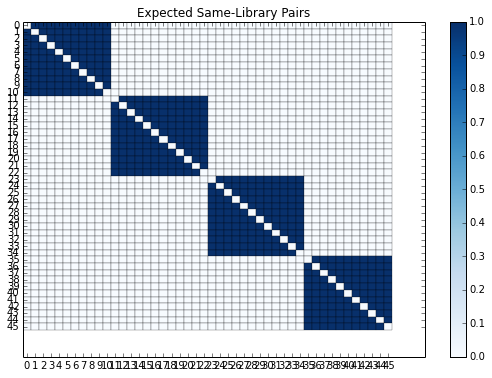

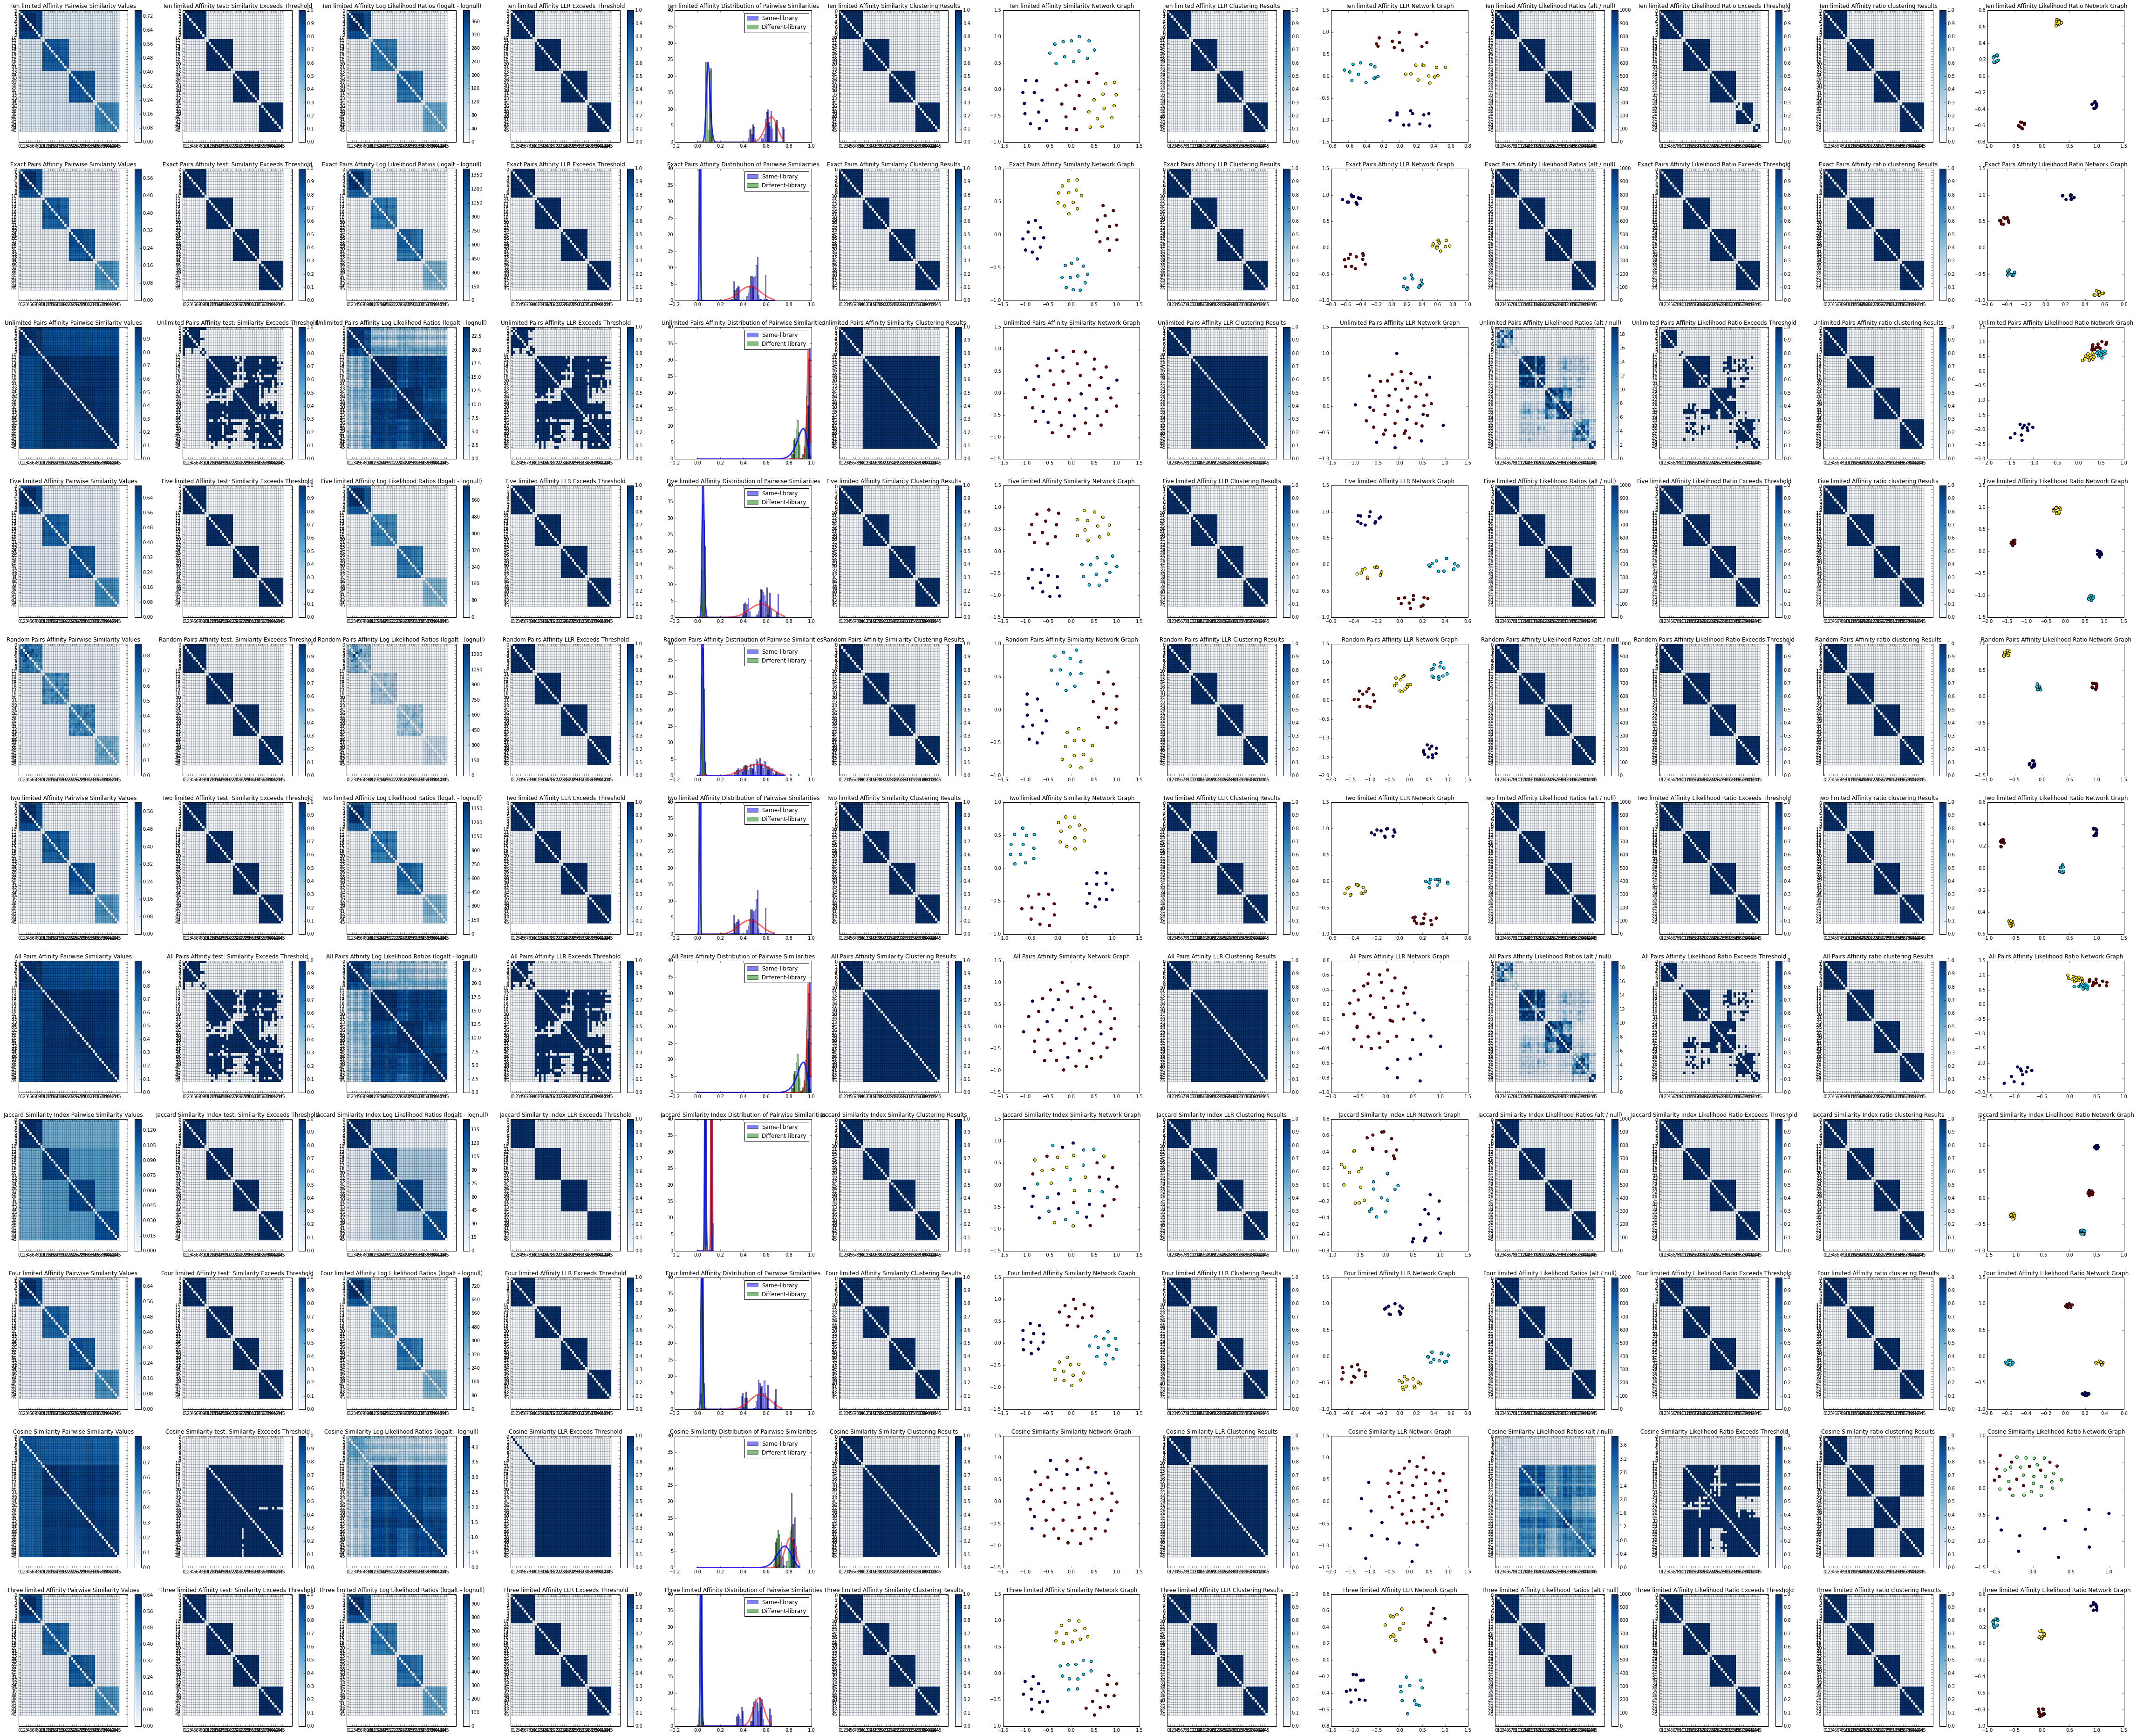

In [62]:
run_all("noF", "ice_only")

1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
evaluation criteria


/Library/Python/2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: overflow encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


p(different-library | truly different-library)  \
All Pairs Affinity                                                    1.0   
Cosine Similarity                                                     1.0   
Exact Pairs Affinity                                                  1.0   
Five limited Affinity                                                 1.0   
Four limited Affinity                                                 1.0   
Jaccard Similarity Index                                              1.0   
Random Pairs Affinity                                                 1.0   
Ten limited Affinity                                                  1.0   
Three limited Affinity                                                1.0   
Two limited Affinity                                                  1.0   
Unlimited Pairs Affinity                                              1.0   

                           p(same-library | truly same-library)   rand index  \
All Pairs Affinity                                          1.0          1.0   
Cosine Similarity                                           1.0          1.0   
Exact Pairs Affinity                                        1.0          1.0   
Five limited Affinity                                       1.0          1.0   
Four limited Affinity                                       1.0          1.0   
Jaccard Similarity Index                                    1.0          1.0   
Random Pairs Affinity                                       1.0          1.0   
Ten limited Affinity                                        1.0          1.0   
Three limited Affinity                                      1.0          1.0   
Two limited Affinity                                        1.0          1.0   
Unlimited Pairs Affinity                                    1.0          1.0   

                          Cluster p(different-library | truly different-library)  \
All Pairs Affinity                                                      1.0        
Cosine Similarity                                                       1.0        
Exact Pairs Affinity                                                    1.0        
Five limited Affinity                                                   1.0        
Four limited Affinity                                                   1.0        
Jaccard Similarity Index                                                1.0        
Random Pairs Affinity                                                   1.0        
Ten limited Affinity                                                    1.0        
Three limited Affinity                                                  1.0        
Two limited Affinity                                                    1.0        
Unlimited Pairs Affinity                                                1.0        

                          Cluster p(same-library | truly same-library)  \
All Pairs Affinity                                                 1.0   
Cosine Similarity                                                  1.0   
Exact Pairs Affinity                                               1.0   
Five limited Affinity                                              1.0   
Four limited Affinity                                              1.0   
Jaccard Similarity Index                                           1.0   
Random Pairs Affinity                                              1.0   
Ten limited Affinity                                               1.0   
Three limited Affinity                                             1.0   
Two limited Affinity                                               1.0   
Unlimited Pairs Affinity                                           1.0   

                          Cluster rand index  Dist Clusters discovered  \
All Pairs Affinity                       1.0                         4   
Cosine Similarity                        1.0                         4   
Exact Pairs Affinity 

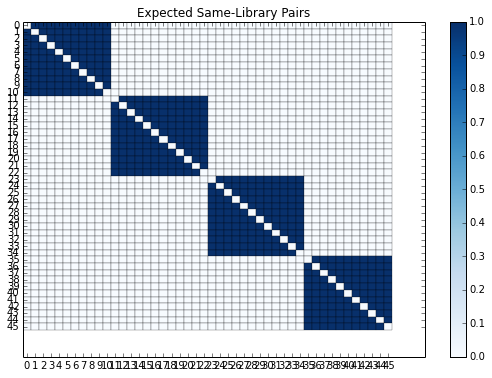

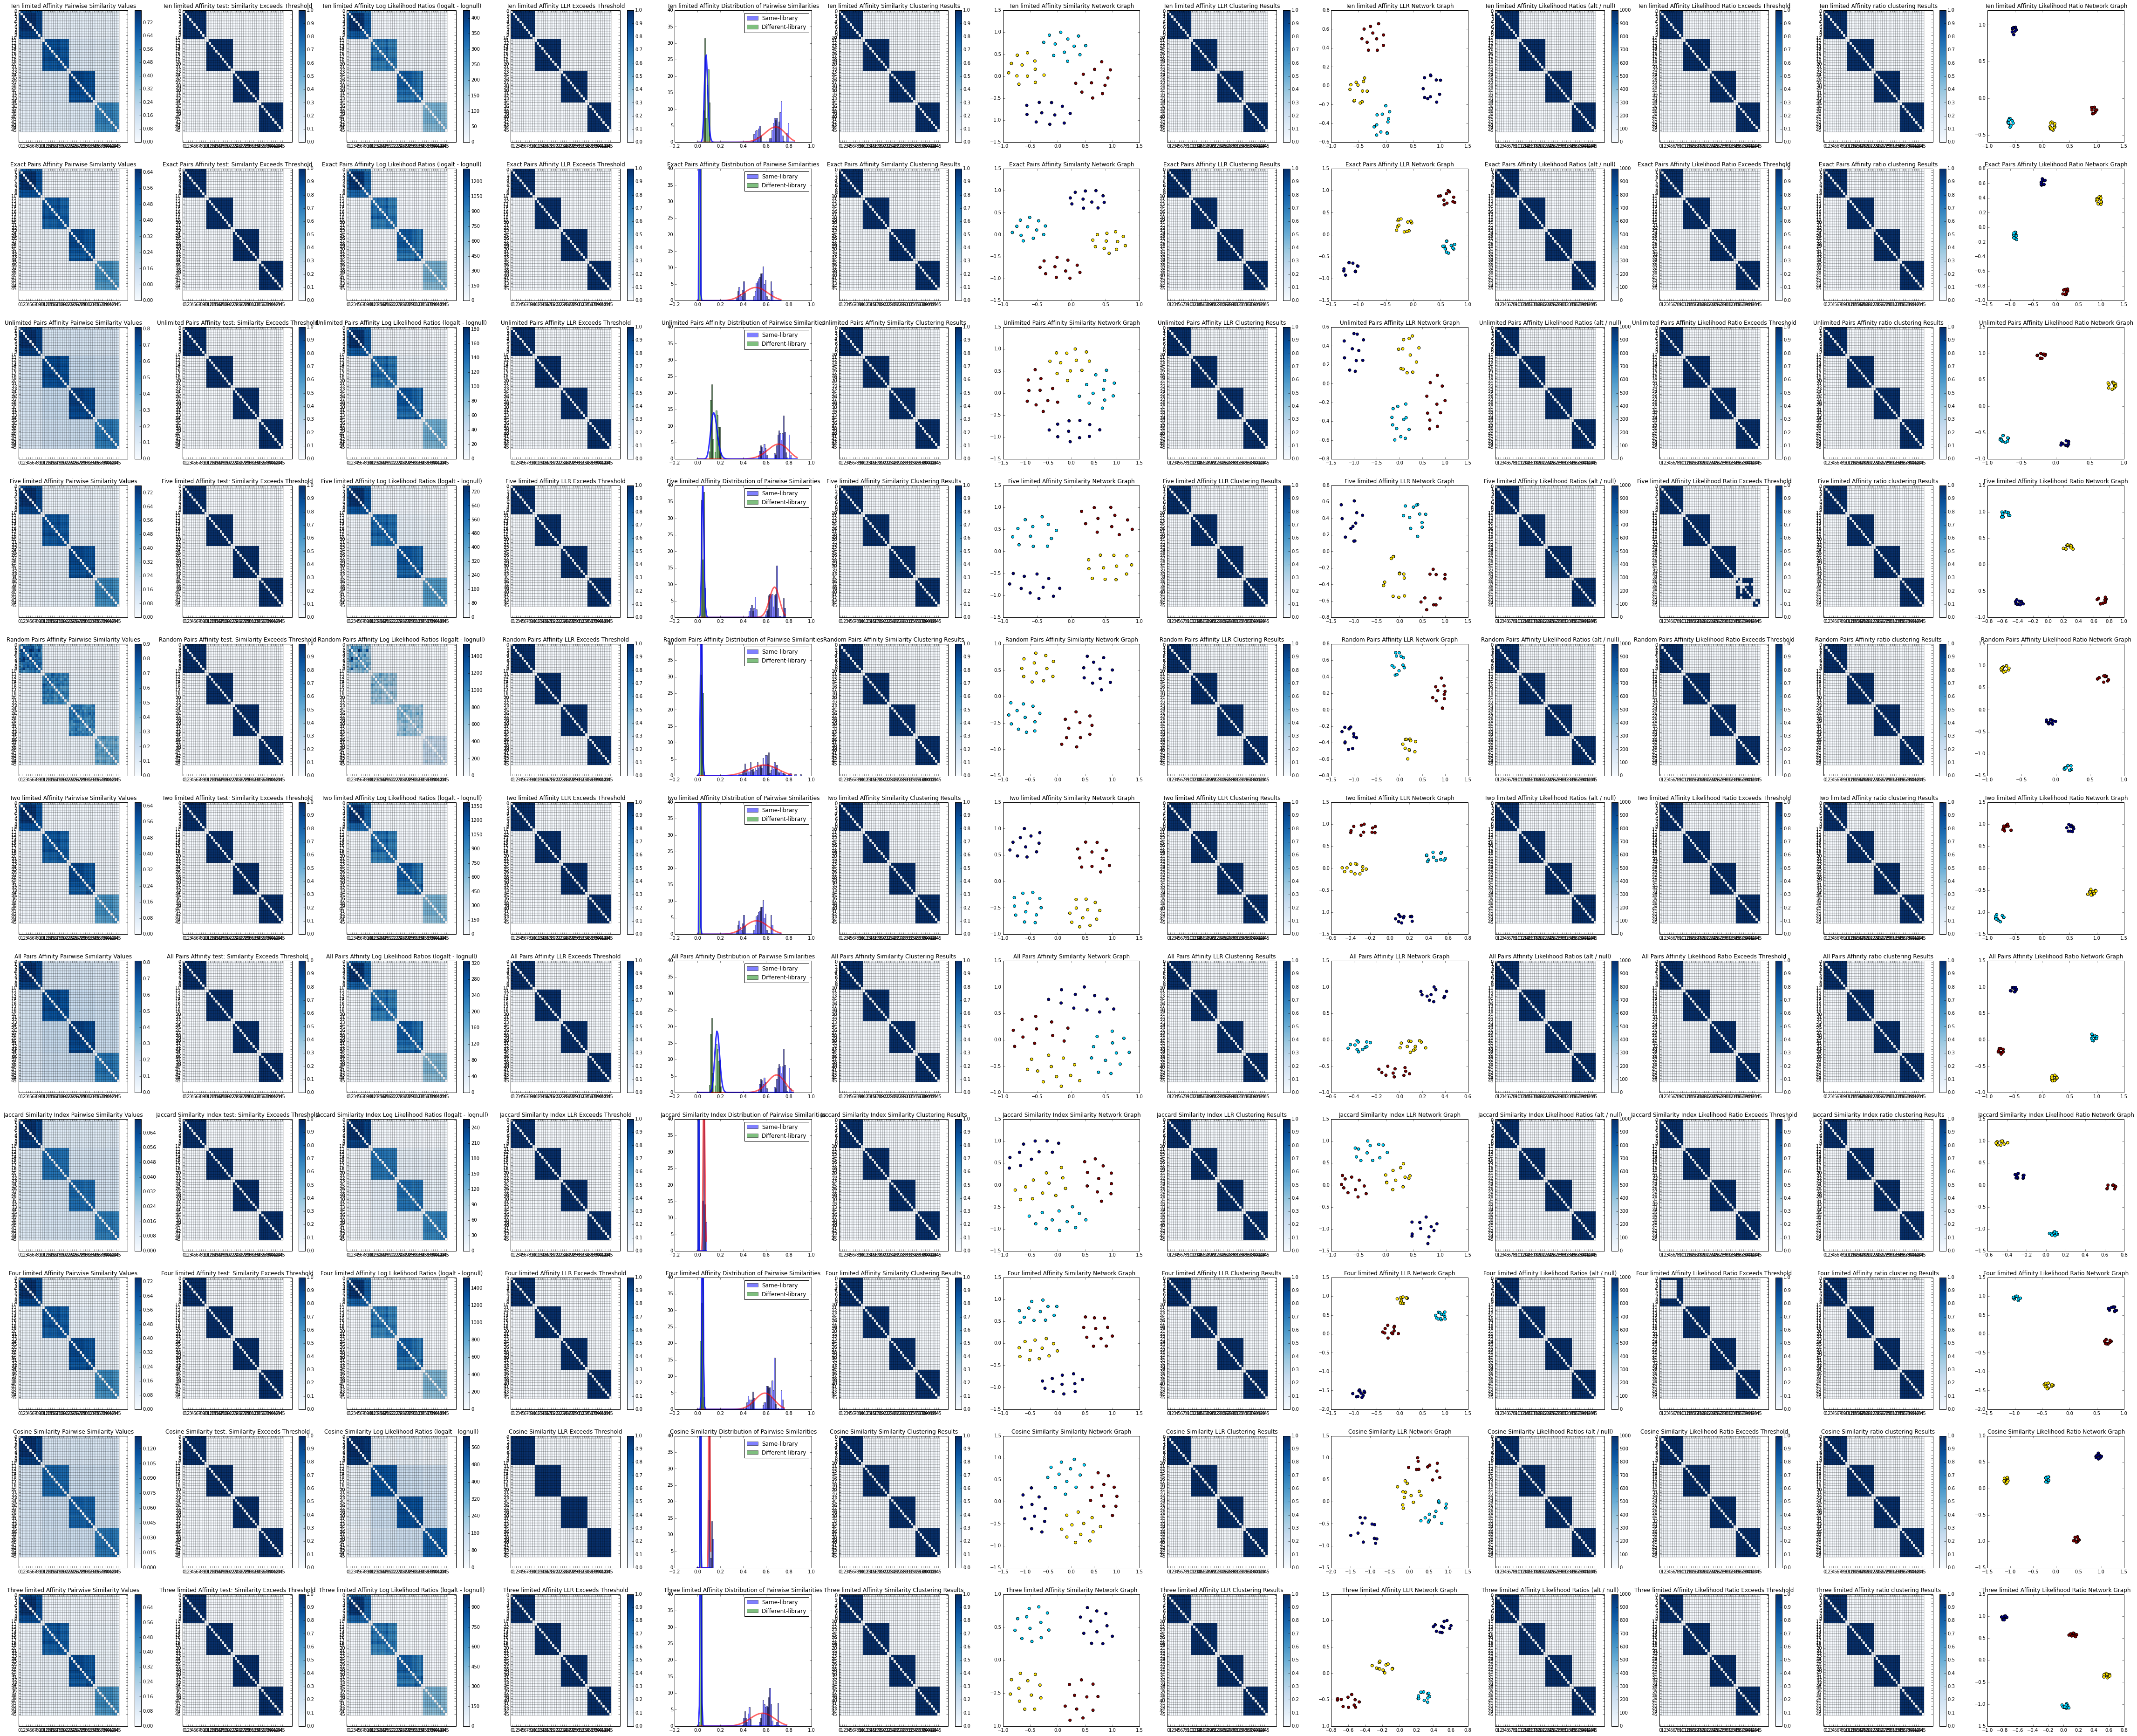

In [63]:
run_all("feb", "ice_only")

In [ ]:
data_types = ["pcr_free", "pcr_plus", "ice_only", "agilent_only", "exomes", "two_sense","strand_agnostic", "rna"] #, "pcr_free", "pcr_plus", "genomes", "combined"] # Omit genomes_new, combined due to inclusion of PCR-free
labels = []
metrics = {}
for j in xrange(len(data_types)):
    data = data_types[j]
    print "evaluating {}".format(data)
    distance_files = { \
              "All Pairs Affinity" : "feb_test_{}_libraries.ap_affinity.csv".format(data), \
              "Exact Pairs Affinity" : "feb_test_{}_libraries.ep_affinity.csv".format(data), \
              "Jaccard Similarity Index" : "feb_test_{}_libraries.jaccard.csv".format(data), \
              "Cosine Similarity" : "feb_test_{}_libraries.cosine.csv".format(data), \
              "Random Pairs Affinity" : "feb_test_{}_libraries.random.csv".format(data), \
              "Unlimited Pairs Affinity" : "feb_test_{}_libraries.unlimited.csv".format(data), \
              "Ten limited Affinity" : "feb_test_{}_libraries.ten.csv".format(data), \
              "Five limited Affinity" : "feb_test_{}_libraries.five.csv".format(data), \
              "Four limited Affinity" : "feb_test_{}_libraries.four.csv".format(data), \
              "Three limited Affinity" : "feb_test_{}_libraries.three.csv".format(data), \
              "Two limited Affinity" : "feb_test_{}_libraries.two.csv".format(data) \
             }
    metadata_file = "feb_test_{}_libraries.read_groups.json".format(data)

    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
#     plot_matrix(truth, title="Expected Same-Library Pairs")
    
#     fig = plt.figure(2, figsize=(45, 6*len(distance_files)))
    i = 0
    evaluation_criteria = None
    for test_label, test_file in distance_files.iteritems():
        i += 1
        print "evaluating {}".format(test_label)
        distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
        evaluation, false_calls = run_experiment(distance, len(groups), test_label, truth, min_max_mean, np.mean, False, None, len(distance_files), i)
        if i == 1:
            evaluation_criteria = evaluation
            all_false_calls = false_calls
        else:
            evaluation_criteria = evaluation_criteria.append(evaluation)#, ignore_index=True)
            if false_calls is not None:
                if all_false_calls is None:
                    all_false_calls = false_calls
                else:
                    all_false_calls = all_false_calls.append(false_calls)
    
    # Gather up some of the metrics sliced from our broader evaluation criteria
    per_type_metrics = { \
        "LLR_rand_index" : evaluation_criteria["LLR rand index"], \
        "LLR_sensitivity" : evaluation_criteria["LLR p(same-library | truly same-library)"], \
        "LLR_specificity" : evaluation_criteria["LLR p(different-library | truly different-library)"], \
        "Cluster_rand_index" : evaluation_criteria["Cluster rand index"], \
        "Cluster_sensitivity" : evaluation_criteria["Cluster p(same-library | truly same-library)"], \
        "Cluster_specificity" : evaluation_criteria["Cluster p(different-library | truly different-library)"], \
        "LLR_cluster_rand_index" : evaluation_criteria["LLR Cluster rand index"], \
        "LLR_cluster_sensitivity" : evaluation_criteria["LLR Cluster p(same-library | truly same-library)"], \
        "LLR_cluster_specificity" : evaluation_criteria["LLR Cluster p(different-library | truly different-library)"], \
        "ratio_rand_index" : evaluation_criteria["ratio rand index"], \
        "ratio_sensitivity" : evaluation_criteria["ratio p(same-library | truly same-library)"], \
        "ratio_specificity" : evaluation_criteria["ratio p(different-library | truly different-library)"], \
        "ratio_cluster_rand_index" : evaluation_criteria["Ratio Cluster rand index"], \
        "ratio_cluster_sensitivity" : evaluation_criteria["Ratio Cluster p(same-library | truly same-library)"], \
        "ratio_cluster_specificity" : evaluation_criteria["Ratio Cluster p(different-library | truly different-library)"] \
    }
    
    
    if j == 0:
        labels = [data]
        
        # wrap each metric in a dataframe and keep hold of it as the nucleus for our growing list
        for key, value in per_type_metrics.iteritems():
            metrics[key] = pd.DataFrame(value)
        
    else:
        labels.append(data)
        
        # concatenate the new data-types metrics to our existing ones.
        for key, value in metrics.iteritems():
            metrics[key] = pd.concat([metrics[key], per_type_metrics[key]], axis=1)
        
#         LLR_rand_index = pd.concat([LLR_rand_index, LLR_rand], axis=1)
#         LLR_sensitivity = pd.concat([LLR_sensitivity, LLR_sens], axis=1)
#         LLR_specificity = pd.concat([LLR_specificity, LLR_spec], axis=1)
        
#         Cluster_rand_index = pd.concat([Cluster_rand_index, Cluster_rand], axis=1)
#         Cluster_sensitivity = pd.concat([Cluster_sensitivity, Cluster_sens], axis=1)
#         Cluster_specificity = pd.concat([Cluster_specificity, Cluster_spec], axis=1)
        
#     LLR_rand_index.columns=labels
#     LLR_sensitivity.columns=labels
#     LLR_specificity.columns=labels
    
#     Cluster_rand_index.columns=labels
#     Cluster_sensitivity.columns=labels
#     Cluster_specificity.columns=labels
    
    # update the labels and do a diagnostic print
    for key, value in metrics.iteritems():
        metrics[key].columns=labels    
        print key
        display(metrics[key])
    
    
#     display(LLR_sensitivity)
#     display(LLR_specificity)
    
#     display(Cluster_rand_index)
#     display(Cluster_sensitivity)
#     display(Cluster_specificity)

    

In [ ]:
for key, value in metrics.iteritems():
    metrics[key] = metrics[key].sort_index()

In [ ]:
fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["LLR_sensitivity"], "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True)
plot_scatter(metrics["Cluster_specificity"], metrics["Cluster_sensitivity"], "Specificity", "Sensitivity", "Distance Clustering Performance by Dataset", ax=plot2)
plot_scatter(metrics["ratio_cluster_specificity"], metrics["ratio_cluster_sensitivity"], "Specificity", "Sensitivity", "Ratio Clustering Performance by Dataset", ax=plot3)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(metrics["LLR_specificity"], metrics["Cluster_specificity"], "Pairwise Specificity", "Clustering Specificity", "Pairwise vs Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_specificity"], metrics["ratio_cluster_specificity"], "Pairwise Specificity", "Ratio Clustering Specificity", "Pairwise vs Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_specificity"], metrics["ratio_cluster_specificity"], "Clustering Specificity", "Ratio Clustering Specificity", "Clustering vs Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "LLR Pairwise Sensitivity", "Clustering Sensitivity", "LLR Pairwise vs Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=True)
plot_scatter(metrics["LLR_sensitivity"], metrics["ratio_cluster_sensitivity"], "LLR Pairwise Sensitivity", "Ratio Clustering Sensitivity", "LLR Pairwise vs Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(metrics["Cluster_sensitivity"], metrics["ratio_cluster_sensitivity"], "Cluster Sensitivity", "Ratio Clustering Sensitivity", "Clustering vs Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [ ]:
distances = metrics["LLR_specificity"].index
print len(metrics)
print len(distances)
n_distances = len(distances)
fig = plt.figure(figsize=(24, 6*n_distances))
for i in xrange(n_distances):
    # Snip out the single metric we are interested in, across all datasets
    distance = distances[i]
    Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
    Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T
    
    Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
    Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T
    
    LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
    LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T
    
    # Get the appropriate axes
    plot_columns = 3
    cell_adjustment = i * plot_columns
    L_plot = fig.add_subplot(n_distances, plot_columns, cell_adjustment + 1)
    C_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 2))
    LC_plot = fig.add_subplot(n_distances, plot_columns, (cell_adjustment + 3))
    
    # Only display the legend once
    doLegend = (i==0)
    
    plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance "+distance, ax=L_plot, display_legend=doLegend)
    plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Distance Clustering Performance "+distance, ax=C_plot, display_legend=False)
    plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Ratio Clustering Performance "+distance, ax=LC_plot, display_legend=False)




In [ ]:
distance = u'Exact Pairs Affinity'

Lsp = pd.DataFrame(metrics["LLR_specificity"].loc[distance]).T
Lse = pd.DataFrame(metrics["LLR_sensitivity"].loc[distance]).T

Csp = pd.DataFrame(metrics["Cluster_specificity"].loc[distance]).T
Cse = pd.DataFrame(metrics["Cluster_sensitivity"].loc[distance]).T

LCsp = pd.DataFrame(metrics["ratio_cluster_specificity"].loc[distance]).T
LCse = pd.DataFrame(metrics["ratio_cluster_sensitivity"].loc[distance]).T

Rsp = pd.DataFrame(metrics["ratio_specificity"].loc[distance]).T
Rse = pd.DataFrame(metrics["ratio_sensitivity"].loc[distance]).T


fig = plt.figure(1, figsize=(24,6))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)
plot_scatter(Lsp, Lse, "Specificity", "Sensitivity", "LLR Pairwise Performance by Dataset", ax=plot1, display_legend=True, draw_nineties=True)
plot_scatter(Csp, Cse, "Specificity", "Sensitivity", "Similarity Clustering Performance by Dataset", ax=plot2, draw_nineties=True)
plot_scatter(LCsp, LCse, "Specificity", "Sensitivity", "Likelihood Ratio Clustering Performance by Dataset", ax=plot3, draw_nineties=True)


fig2 = plt.figure(2, figsize=(24,6))
plot21 = fig2.add_subplot(131)
plot22 = fig2.add_subplot(132)
plot23 = fig2.add_subplot(133)
plot_scatter(Lsp, Csp, "LLR Pairwise Specificity", "Similarity Clustering Specificity", "LLR Pairwise vs Similarity Clustering Specificity by Dataset", ax=plot21, draw_line=True, display_legend=False)
plot_scatter(Lsp, LCsp, "LLR Pairwise Specificity", "Likelihood Ratio Clustering Specificity", "LLR Pairwise vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot22, draw_line=True, display_legend=False)
plot_scatter(Csp, LCsp, "Similarity Clustering Specificity", "Likelihood Ratio Clustering Specificity", "Similarity Clustering vs Likelihood Ratio Clustering Specificity by Dataset", ax=plot23, draw_line=True, display_legend=False)


fig3 = plt.figure(3, figsize=(24,6))
plot31 = fig3.add_subplot(131)
plot32 = fig3.add_subplot(132)
plot33 = fig3.add_subplot(133)
plot_scatter(Lse, Cse, "LLR Pairwise Sensitivity", "Similarity Clustering Sensitivity", "LLR Pairwise vs Similarity Score Clustering Sensitivity by Dataset", ax=plot31, draw_line=True, display_legend=False)
plot_scatter(Lse, LCse, "LLR Pairwise Sensitivity", "Likelihood Ratio Clustering Sensitivity", "LLR Pairwise vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot32, draw_line=True, display_legend=False)
plot_scatter(Cse, LCse, "Similarity Clustering Sensitivity", "Likelihood Ratio Clustering Sensitivity", "Similarity Clustering vs Likelihood Ratio Clustering Sensitivity by Dataset", ax=plot33, draw_line=True, display_legend=False)

# plot_scatter(metrics["LLR_sensitivity"], metrics["Cluster_sensitivity"], "Pairwise Sensitivity", "Clustering Sensitivity", "Pairwise vs Clustering Specificity by Dataset", ax=plot22, draw_line=True)

In [58]:
my_table = read_table("noF_test_ice_only_libraries.table.json")

In [59]:
keycount = 0
minkey = 1000
maxkey = -1
for key, value in my_table.iteritems():
    if -1 in key:
        print key
    if not key:
        print "NOT KEY",
        print key
    else:
        if 0 in key:
            keycount += 1
        if max(key) > maxkey: maxkey = max(key)
        if min(key) < minkey: minkey = min(key)

        if value < 1:
            print key,
            print " : ",
            print value
print "done"
print keycount
print maxkey
print minkey
print len(my_table.keys())

done
334396
45
0
2328827


In [46]:
meta = read_metadata("feb_test_pcr_plus_libraries.read_groups.json")

In [47]:
keys = [key for key in meta.iterkeys()]
keys

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52]